In [1]:
# !pip install pandas-profiling
# !pip install scikit-learn==1.1.3
# !pip install skorch

# Прогнозирование температуры звезды

**Содержание:**  
1. [Загрузка данных и общая информация](#load_and_info)  
 1.1. [Импорт библиотек](#import)  
 1.2. [Загрузка данных](#read)  
 1.3. [Общая информация](#info)  
    
    
2. [Предобработка данных](#preparation)  
 2.1. [Предобработка числовых значений](#preparation_num)  
 2.2. [Предобработка категориальных значений](#preparation_cat)
 
 
3. [Исследовательский анализ данных](#eda)  
 3.1. [Признак "star_type"](#eda_star_type)  
 3.2. [Признак "star_color"](#eda_star_color)  
 3.3. [Числовые признаки](#eda_num)  


4. [Подготовка данных к построению нейросети](#preparation_network)  
 4.1. [Масштабирование числовых и кодирование (OHE) категориальных значений](#preparation_ohe)  
 
 
5. [Построение базовой нейронной сети](#base_network)  


6. [Улучшение нейронной сет](#no_base_network)  
 6.1. [Подбор гиперпараметров](#hyper)  
 6.2. [Проверка на тестовой выборке](#test)  
 

7. [Выводы](#final)  

**Заказчик исследования:** обсерватории "Небо на ладони".  
**Цель исследования:** построить нейросеть, с помощью которой можно определить температуру на поверхности обнаруженных звёзд.


**Исходные данные:**  
Исходные данные представлены в датесете 6_class.csv;

В датасете содержатся следующие признаки:  
- Temperature (K) - абсолютная температура (температура на поверхности звезды в Кельвинах);
- Luminosity(L/Lo) — относительная светимость (светимость звезды относительно Солнца);
- Radius(R/Ro) - относительный радиус (радиус звезды относительно радиуса Солнца);
- Absolute magnitude(Mv) - абсолютная звёздная величина (физическая величина, характеризующая блеск звезды);
- Star type - тип звезды;
- Star color - звёздный цвет (цвет звезды, который определяют на основе спектрального анализа).

**Требования к качеству прогнозирования:** значение RMSE не должно превышать 4500.

## Загрузка данных и общая информация
<a id="load_and_info"></a>

### Импорт библиотек
<a id="import"></a>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import ydata_profiling

from functools import partial
from numpy import sqrt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

### Загрузка данных
<a id="read"></a>

In [5]:
df = pd.read_csv('/datasets/6_class.csv')

### Общая информация
<a id="info"></a>

In [6]:
# df.profile_report()

In [7]:
object_list = ['Star color']

def inf(df_info):
    print()
    print('Общая информация:')
    display(df_info.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Уникальные значения строковых признаков:')
    for i in object_list:
        print('{}:'.format(i))
        print(df_info[i].unique())
        print()
    print('Описательная статистика строковых значений:')
    display(df_info.describe(include='object').T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_info.describe().T)
    print('_' * 50)
    print()
    print('Процент пропущенных значений:')
    display(df_info.isna().mean()*100)
    print('_' * 50)
    print()
    print('Случайная выборка датафрейма:')
    display(df_info.sample(n = 5, random_state = 0))
    print('_' * 100)

In [8]:
inf(df)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 26.0 KB


None

__________________________________________________

Уникальные значения строковых признаков:
Star color:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']

Описательная статистика строковых значений:


count unique  top freq
Star color   240     19  Red  112

__________________________________________________

Описательная статистика числовых значений:


count           mean            std         min  \
Unnamed: 0              240.0     119.500000      69.426220     0.00000   
Temperature (K)         240.0   10497.462500    9552.425037  1939.00000   
Luminosity(L/Lo)        240.0  107188.361635  179432.244940     0.00008   
Radius(R/Ro)            240.0     237.157781     517.155763     0.00840   
Absolute magnitude(Mv)  240.0       4.382396      10.532512   -11.92000   
Star type               240.0       2.500000       1.711394     0.00000   

                                25%        50%          75%        max  
Unnamed: 0                59.750000   119.5000     179.2500     239.00  
Temperature (K)         3344.250000  5776.0000   15055.5000   40000.00  
Luminosity(L/Lo)           0.000865     0.0705  198050.0000  849420.00  
Radius(R/Ro)               0.102750     0.7625      42.7500    1948.50  
Absolute magnitude(Mv)    -6.232500     8.3130      13.6975      20.06  
Star type                  1.000000     2.5000       4.0000       5.00

__________________________________________________

Процент пропущенных значений:


Unnamed: 0                0.0
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


Unnamed: 0  Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  \
109         109            33421        352000.000        67.000   
71           71             3607             0.022         0.380   
37           37             6380             1.350         0.980   
74           74             3550             0.004         0.291   
108         108            24345        142000.000        57.000   

     Absolute magnitude(Mv)  Star type    Star color  
109                   -5.79          4          Blue  
71                    10.12          1           Red  
37                     2.93          3  yellow-white  
74                    10.89          1           Red  
108                   -6.24          4          Blue

____________________________________________________________________________________________________


1. В датафрейме 240 строк и 7 признаков. Признак "Unnamed: 0" - лишний: дублирует индексы датафрейма.
2. Пропущенные значения отсутствуют.  
3. Следующие признаки имеют тип int64:  
 - Unnamed: 0;  
 - Temperature (K);  
 - Star type.  
 
 Следующие признаки имеют тип object:  
  - Star color.   

 Следующие признаки имеют тип float64:  
  - Luminosity(L/Lo);   
  - Radius(R/Ro);   
  - Absolute magnitude(Mv).   
  
  
4. Уникальные значения признака "Star color" не в полной мере соответствуют <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>: вперемешку идет классификация по обычному описанию цвета и фактически видимому цвету.  
5. Максимальное значение признака "Temperature (K)" в 2.65 раз выше значения третьего квартиля.
6. Максимальное значение признака "Luminosity(L/Lo)" в 4.29 раз выше значения третьего квартиля.
7. Максимальное значение признака "Radius(R/Ro)" в 45.58 раз выше значения третьего квартиля.  
8. Максимальное значение признака "Absolute magnitude(Mv)" в 1.46 раз выше значения третьего квартиля.

## Предобработка данных
<a id="preparation"></a>

Удаляем признак "Unnamed: 0":

In [9]:
df = df.drop('Unnamed: 0', axis=1)

Приводим названия признаков в соответствие с требованиями PEP 8:

In [10]:
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Создаем списки категориальных и числовых значений:

In [11]:
cat_list = ['star_type', 'star_color']
num_list = ['luminosity', 'radius', 'temperature', 'absolute_magnitude']

### Предобработка числовых значений
<a id="preparation_num"></a>

Строим диаграммы размаха для числовых значений:

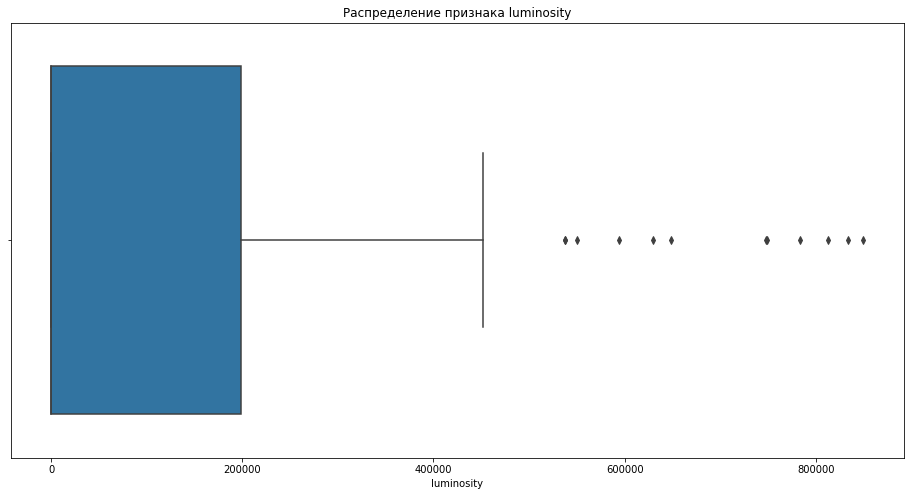

Минимальное значение - 8e-05, максимальное значение - 849420.0.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


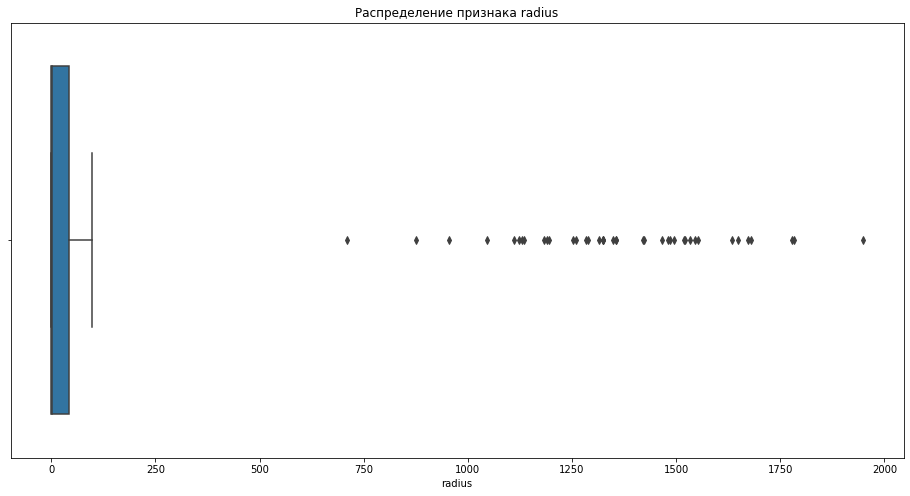

Минимальное значение - 0.0084, максимальное значение - 1948.5.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


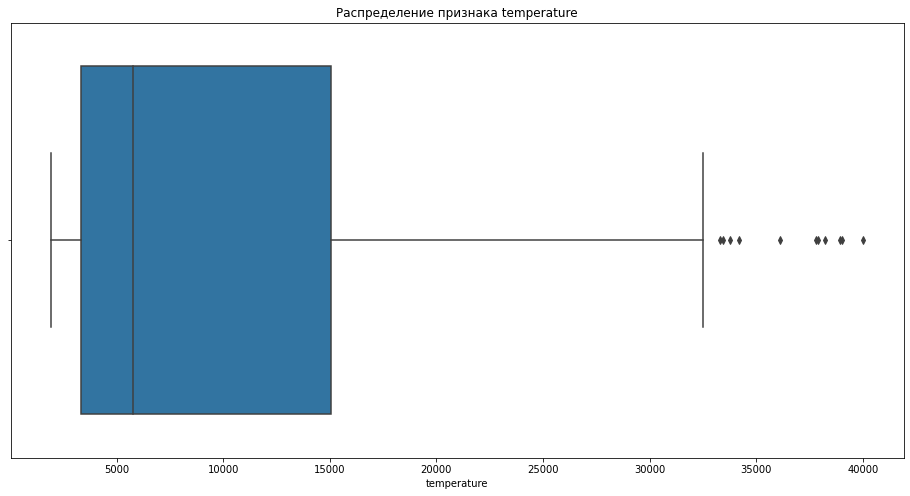

Минимальное значение - 1939, максимальное значение - 40000.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


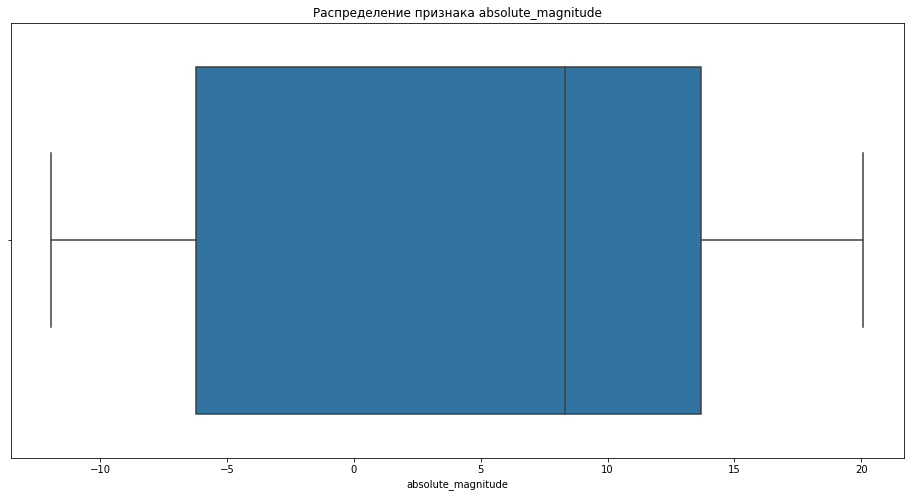

Минимальное значение - -11.92, максимальное значение - 20.06.

____________________________________________________________________________________________________
____________________________________________________________________________________________________


In [12]:
for i in num_list:
    fig = plt.figure(figsize=(16,8))                               # создаем поле диаграммы
    ax1 = sns.boxplot(x=df[i])                                     # создаем диаграмму
    ax1 = plt.title('Распределение признака {}'.format(i))         # создаем заголовок диаграммы
    ax1 = plt.xlabel(i)                                            # подпись оси x
    plt.show()
    
    min_value = df[i].min()                                        # находим минимальное значение
    max_value = df[i].max()                                        # находим максимальное значение
    print('Минимальное значение - {}, максимальное значение - {}.'.format(min_value, max_value))
    print()
    print('_' * 100)
    print('_' * 100)

У числовых признаков "luminosity", "radius" и "temperature" все значения больше 0. Значения признака "absolute_magnitude" могут быть отрицательные, положительные и равные нулю.  
У признаков "luminosity", "radius" и "temperature" есть выбросы в большую сторону. Удалим из рассмотрении я объекты, если таковые имеются, у которых значения данных признаков превышают максимальные значения среди всех известных объектов:
- "luminosity" - максимальное значение 8710000 L/Lo (для звезды <a href="https://infogalactic.com/info/R136a1">R136</a>);
- "radius" - максимальное значение 1708±192 R/Ro (для звезды <a href="https://infogalactic.com/info/UY_Scuti">UY Scuti</a>);
- "temperature" - максимальное значение 210000 K (для звезды <a href="https://infogalactic.com/info/WR_102">WR 102</a>).

In [13]:
lum_max = 8710000
radius_max = 1708+192
temp_max = 210000

Проверяем объекты на аномальность признаков (значения выше максимальных):

In [14]:
param_dict = {'luminosity' : lum_max, 'radius' : radius_max, 'temperature' : temp_max}
for key, value in param_dict.items():
    anomal_cnt = df.loc[df[key] > value]
    print('Количество аномальных значений признака {} - {}.'.format(key, anomal_cnt.shape[0]))
    if anomal_cnt.shape[0] > 0:
        display(anomal_cnt)
    print('_' * 100)
    print('_' * 100)
    print()

Количество аномальных значений признака luminosity - 0.
____________________________________________________________________________________________________
____________________________________________________________________________________________________

Количество аномальных значений признака radius - 1.


temperature  luminosity  radius  absolute_magnitude  star_type star_color
232        32489    648430.0  1948.5              -10.84          5       Blue

____________________________________________________________________________________________________
____________________________________________________________________________________________________

Количество аномальных значений признака temperature - 0.
____________________________________________________________________________________________________
____________________________________________________________________________________________________



В датафрейме 1 объект с признаком, превышающем значения соответственного признака всех официально зарегистрированных объектов. Относительный радиус объекта с индексом 242 на 2,5% превышает максимальный зарегестрированный.  
Поскольку обсерватория - научно-исследовательское учреждение, можно допускаем, что заказчик предполагает существование объекта с такими экстремальными параметрами, а значит не следует исключать его (объект) из исследования.

### Предобработка категориальных значений
<a id="preparation_cat"></a>

***Признак "star_color"***

Приводим значения признака "star_color" к единой форме: убираем пробелы вначале и в конце строки, заменяем тире на пробелы и переводим в нижний регистр:

In [15]:
df['star_color'] = df.apply(lambda x: x['star_color'].strip().replace('-', ' ').lower(), axis=1)

Значения признака должны соответствовать приведенным в <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>:

In [16]:
class_list = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
temperature_list = ['≥ 30000', '10000–30000', '7500–10000', '6000–7500', '5200–6000', '3700–5200', '2400–3700']
conv_color_list = ['blue', 'blue white', 'white', 'yellow white', 'yellow', 'orange', 'red']
actual_apparent_list = ['blue', 'deep blue white', 'blue white', 'white', 'yellowish white',
                        'pale yellow orange', 'light orange red']
df_class = pd.DataFrame(list(zip(class_list, temperature_list, conv_color_list, actual_apparent_list)),
                        columns =['class', 'temperature', 'conventional_color_description', 'actual_apparent_color'])
df_class

class  temperature conventional_color_description actual_apparent_color
0     O      ≥ 30000                           blue                  blue
1     B  10000–30000                     blue white       deep blue white
2     A   7500–10000                          white            blue white
3     F    6000–7500                   yellow white                 white
4     G    5200–6000                         yellow       yellowish white
5     K    3700–5200                         orange    pale yellow orange
6     M    2400–3700                            red      light orange red

В дата фрейме по цвету часть объектов классифицировано по "conventional_color_description" (по обычному описанию цвета), другая - по "actual_apparent_color" (фактически видимому цвету). Классифицируем все объекты по "actual_apparent_color". Для разных классов  значения "blue white" и "white" у "conventional_color_description" и "actual_apparent_color" совпадают. Значения "blue white" и "white", относящиеся к "conventional_color_description" пометим как "blue white_ccd" и "white_ccd" соответственно:

In [17]:
df.loc[(df['temperature'] > 10000) & (df['temperature'] <= 30000) & (df['star_color'] == 'blue white'), 'star_color'] = 'blue white_ccd'
df.loc[(df['temperature'] > 7500) & (df['temperature'] <= 10000) & (df['star_color'] == 'white'), 'star_color'] = 'white_ccd'

В датафрейме присутствует значение "whitish", которое отсутствует в <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>. Находим среднее значение температуры объектов "whitish" и по нему определяем класс, к которому они принадлежат:

In [18]:
whitish_temp = df.loc[(df['temperature'] > 7500) & (df['temperature'] <= 10000) & (df['star_color'] == 'whitish')]\
                    ['temperature'].mean()
print('Средняя температура звезд, классифицированных как "whitish" - {} K.'.format(whitish_temp))

Средняя температура звезд, классифицированных как "whitish" - 8876.0 K.


Согласно <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a> данные объекты откосятся к классу "blue white" ("actual_apparent_color").

Приводим значения к классификации по "actual_apparent_color":

In [19]:
df['star_color'] = df['star_color'].replace({'red' : 'light orange red',
                                             'blue white_ccd' : 'deep blue white',
                                             'white_ccd' : 'blue white',
                                             'whitish' : 'blue white',
                                             'yellow white' : 'white',
                                             'orange' : 'pale yellow orange',
                                             'white yellow' : 'white',
                                             'yellowish' : 'yellowish white',
                                             'orange red' : 'light orange red'})

Выводим список уникальных значений признака "star_color":

In [20]:
df['star_color'].unique()

array(['light orange red', 'deep blue white', 'blue white', 'white',
       'yellowish white', 'pale yellow orange', 'blue'], dtype=object)

***Признак "star_color"***

Выводим уникальные значения признака "star_type":

In [21]:
df['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

Предобработка значений признака "star_type" не требуется.

**Вывод:**  
1. Названия признаков приведены в соответствие с требованиями PEP 8.
2. Обнаружен 1 объект с аномальным значением признака. Но из исследования он не исключен.
3. Значения признака "star_color" приведены к единой форме. Устранены разночтения в классификации объектов по данному признаку. Количество уникальных значений сокращено с 19 до 7.

## Исследовательский анализ данных
<a id="eda"></a>

### Признак "star_type"
<a id="eda_star_type"></a>

Выводим количество звезд по типу и строим гистограмму:

star_type  star_count  percent
0          0          40     16.7
1          1          40     16.7
2          2          40     16.7
3          3          40     16.7
4          4          40     16.7
5          5          40     16.7

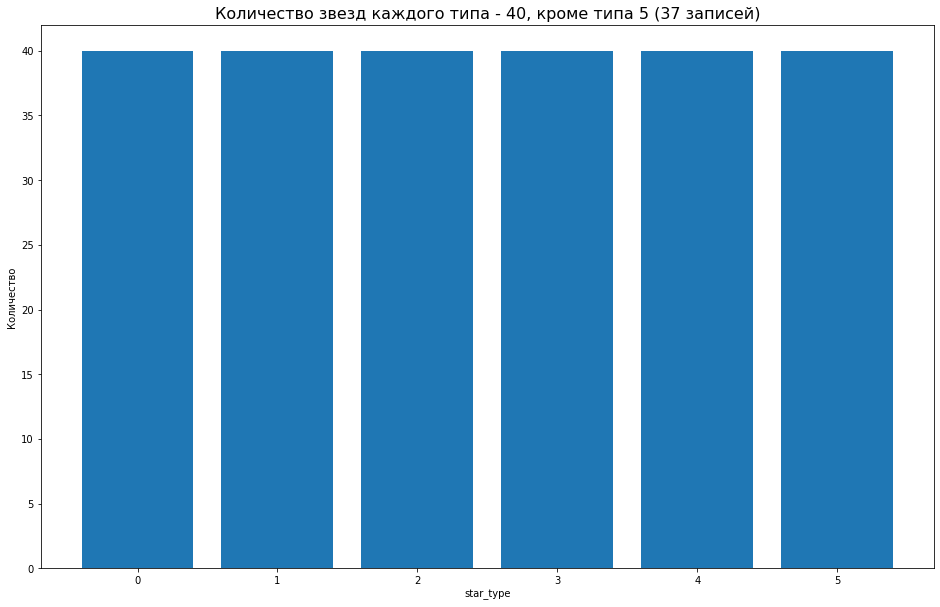

In [22]:
df_star_color = (
    df.groupby('star_type')['temperature']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns = {'temperature' : 'star_count'})
    .assign(percent=lambda x: (100 * x.star_count / df.shape[0]).round(1)) 
)
display(df_star_color)

df_star_color_sort = df_star_color.sort_values(by='star_count', ascending=True)
fig = plt.figure(figsize=(16,10))
plt.bar(df_star_color_sort['star_type'], df_star_color_sort['star_count'])
plt.title('Количество звезд каждого типа - 40, кроме типа 5 (37 записей)', fontsize=16)
plt.ylabel('Количество')
plt.xlabel('star_type')
plt.show()

По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).

### Признак "star_color"
<a id="eda_star_color"></a>

Выводим количество звезд по типу и строим гистограмму:

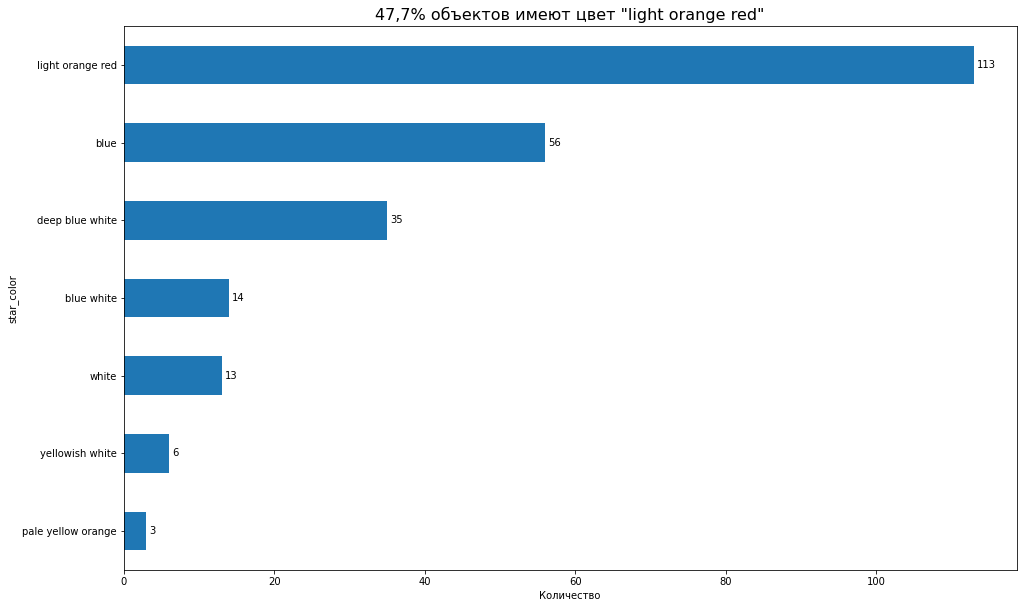

In [23]:
df_star_color = (
    df.groupby('star_color')['temperature']
    .count()
    .sort_values(ascending=True)
)

fig = plt.figure(figsize=(16,10))
ax = df_star_color.plot.barh()
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(3, 0), textcoords='offset points', ha="left", va="center")
plt.title('47,7% объектов имеют цвет "light orange red"', fontsize=16)
plt.ylabel('star_color')
plt.xlabel('Количество')
plt.show()

В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
Количество звезд остальных цветов не превышает 6% для каждого цвета.  

### Числовые признаки
<a id="eda_num"></a>

Строим гистограммы числовых признаков:

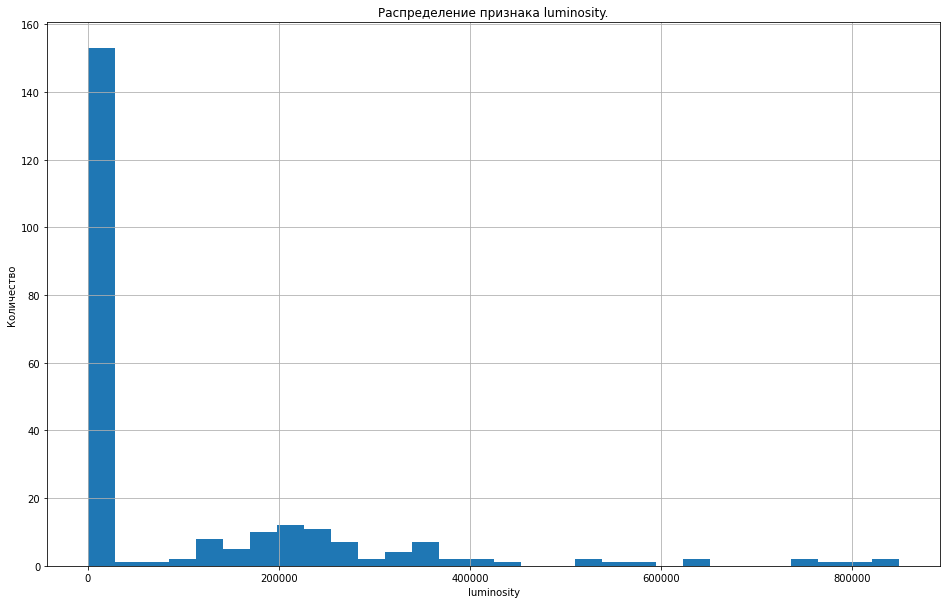

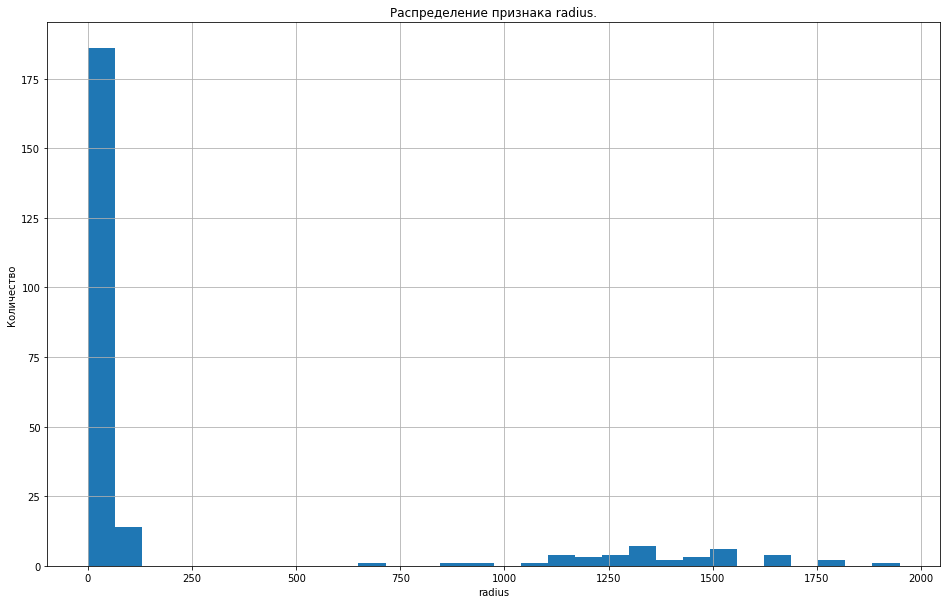

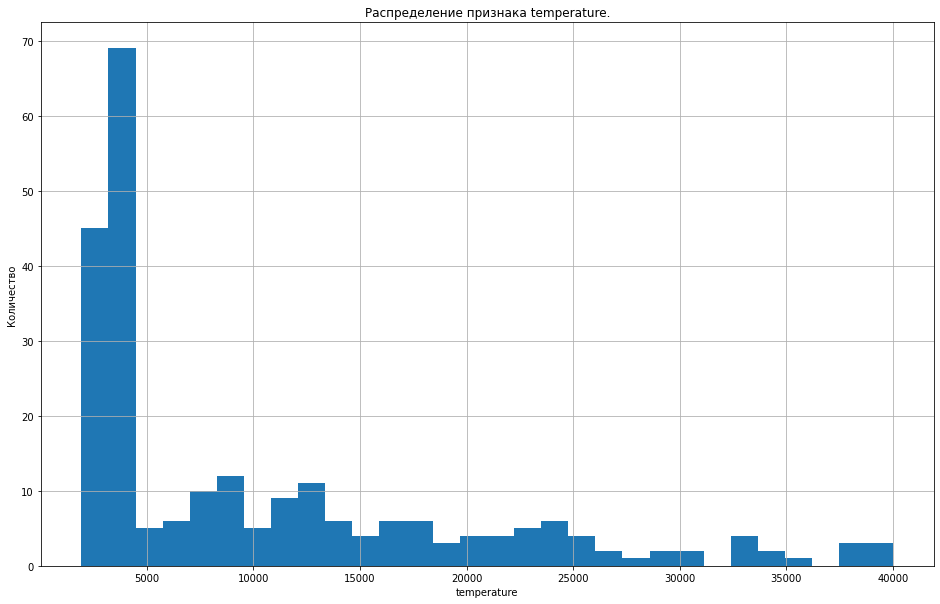

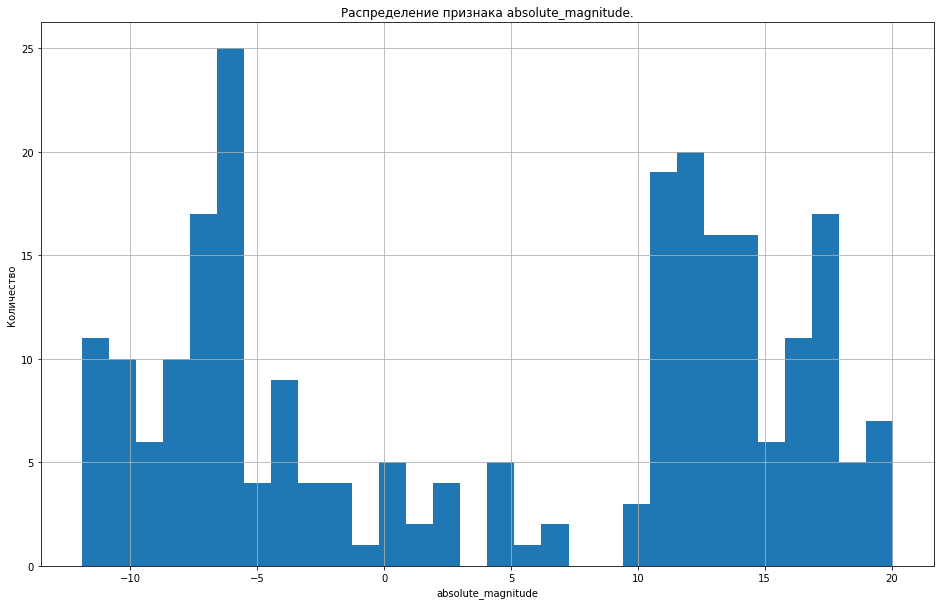

In [24]:
for i in num_list:
    fig = plt.figure(figsize=(16,10))
    df[i].hist(bins=30)
    plt.title('Распределение признака {}.'.format(i))
    plt.ylabel('Количество')
    plt.xlabel(i) 
    plt.show()

Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  

Определим количество звезд больших и меньших, чем Солнце:

In [25]:
def star_size(radius):
    if radius < 1:
        size = 'меньше Солнца'
    elif radius == 0:
        size = 'равно Солнцу'
    else:
        size = 'больше Солнца'
    return size

In [26]:
df['size_class'] = df.apply(lambda x: star_size(x['radius']), axis=1)

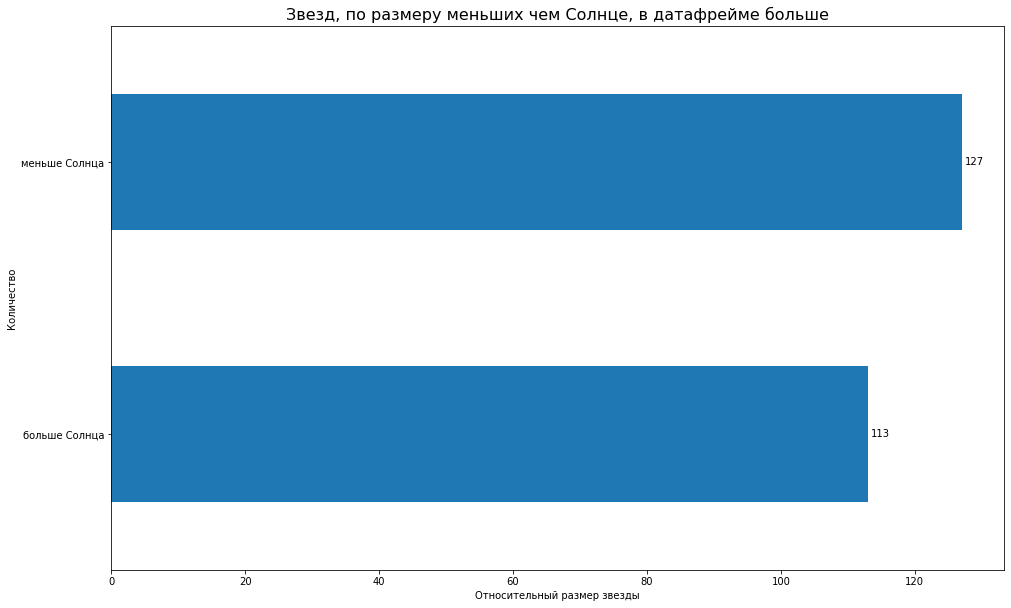

In [27]:
df_star_size = df.groupby('size_class')['temperature'].count()
fig = plt.figure(figsize=(16,10))
ax = df_star_size.plot.barh()
plt.title('Звезд, по размеру меньших чем Солнце, в датафрейме больше', fontsize=16)
plt.ylabel('Количество')
plt.xlabel('Относительный размер звезды')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(3, 0), textcoords='offset points', ha="left", va="center")
plt.show()

Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.

Строим тепловую карту. Во избежание негативного влияния выбросов и нелинейности взаимосвязей признаков для расчёта корреляции применяем коэффициент Спирмена.

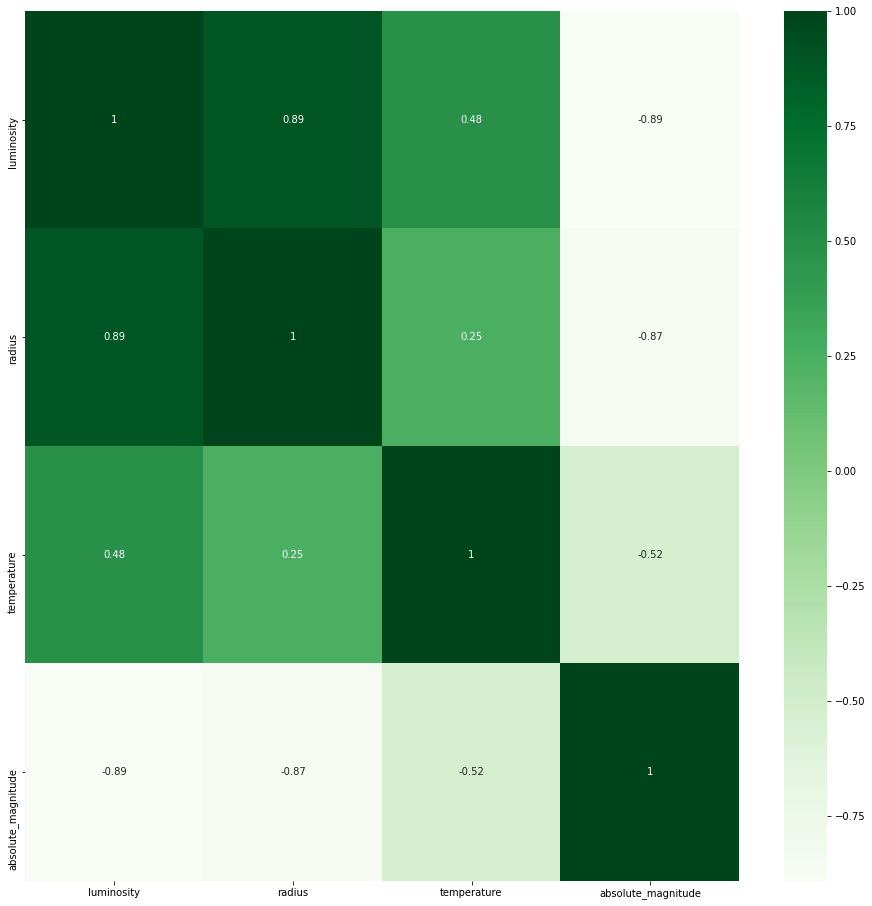

In [28]:
fig = plt.subplots(figsize=(16, 16))
sns.heatmap(df[num_list].corr(method = 'spearman'), annot = True, cmap = 'Greens')
plt.show()

Целевой признак "temperature" имеет значения корреляции с другими признаками:  
- "luminosity": 0.48;
- "radius": 0.25;
- "absolute_magnitude": -0.52.

Наибольшая корреляция между "luminosity" и "radius": 0.89.
Высокая обратная корреляция между:
- "luminosity" и "absolute_magnitude": -0.89;
- "radius" и "absolute_magnitude": -0.87.

Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.

Рассчитываем среднее значение и стандартное отклонение целевого признака "temperature":

In [29]:
print('Среднее значение - {:.1f} K.'.format(df['temperature'].mean()))
print('Стандартное отклонение - {:.1f} K.'.format(df['temperature'].std()))

Среднее значение - 10497.5 K.
Стандартное отклонение - 9552.4 K.


**Вывод:**  
1. По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).  
2. В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
   Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
   Количество звезд остальных цветов не превышает 6% для каждого цвета.  
3. Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
    Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  
4. Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.
5. Целевой признак "temperature" имеет значения корреляции с другими признаками:  

    - "luminosity": 0.48;
    - "radius": 0.25;
    - "absolute_magnitude": -0.52.

 Наибольшая корреляция между "luminosity" и "radius": 0.89.
    Высокая обратная корреляция между:
    - "luminosity" и "absolute_magnitude": -0.89;
    - "radius" и "absolute_magnitude": -0.87.

   Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.
6. Среднее значение целевого признака "temperature" - 10497.5 K.  
    Стандартное отклонение целевого признака "temperature" - 9552.4 K.

## Подготовка данных к построению нейросети
<a id="preparation_network"></a>

Задаем параметр "random_state":

In [30]:
RS = np.random.RandomState(5)

Создаем списки категориальных, числовых признаков и выделяем целевой признак:

In [31]:
cat_features = ['star_type', 'star_color']
num_features = ['luminosity', 'radius', 'absolute_magnitude']
target_param = 'temperature'

Создаем датафрейм признаков и вектор целевого признака:

In [32]:
features = df.drop(['temperature', 'size_class'], axis=1)
target = df[target_param]

Разделяем выборку на обучающую и тестовую:

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, shuffle=True, random_state=RS)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, shuffle=True, random_state=RS)
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

### Масштабирование числовых и кодирование (OHE) категориальных значений
<a id="preparation_ohe"></a>

Класс масштабирования числовых значений:

In [34]:
class ScalerTransformation(BaseEstimator, TransformerMixin): 
    scaler = StandardScaler()
    
    def fit(self, X, y=None):
        X = X.copy()                                               # делаем копию матрицы признаков
        self.scaler.fit(X[num_features])                           # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                               # делаем копию матрицы признаков
#         X = X.reset_index(drop=True)
        X[num_features] = self.scaler.transform(X[num_features])   # масштабируем числовые значения
        return X

Класс кодирования (OHE) категориальных значений:

In [35]:
class OheTransform(BaseEstimator, TransformerMixin): 
    encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
    
    def fit(self, X, y=None):
        X = X.copy()                              # делаем копию матрицы признаков
        self.encoder.fit(X[cat_features])         # обучаем encoder на категориальных данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                                         # делаем копию матрицы признаков
        feature_arr = self.encoder.transform(X[cat_features]).toarray()      # кодируем категориальные значения
        ohe_labels = self.encoder.get_feature_names_out(cat_features)        # создаем список названий новых признаков
        features = pd.DataFrame(                                             # собираем результаты в датафрейм
               feature_arr,
               columns=ohe_labels)
        X = X.join(features)                                                 # добавляем результаты кодирования в исходную таблицу
        X = X.drop(cat_features, axis=1)                                     # удаляем исходные категориальные столбцы
        X.columns = map(str.lower, X.columns)                                # переводим названия столбцов в нижний регистр
        
        return X

Создаем и обучаем pipeline:

In [36]:
pipe = make_pipeline(ScalerTransformation(), OheTransform())
pipe.fit(features_train)

Pipeline(steps=[('scalertransformation', ScalerTransformation()),
                ('ohetransform', OheTransform())])

Преобразовываем обучающую и тестовую выборки:

In [37]:
features_train = pipe.transform(features_train)
features_valid = pipe.transform(features_valid)
features_test = pipe.transform(features_test)

Выводим 5 случайных строк обучающей выборки:

In [38]:
features_train.sample(n=5)

luminosity    radius  absolute_magnitude  star_type_1  star_type_2  \
125   -0.559481 -0.427386            1.248164          0.0          0.0   
109    1.401752 -0.380580           -1.082935          0.0          0.0   
67    -0.559481 -0.427357            1.026335          0.0          0.0   
113   -0.559481 -0.427604            0.721084          0.0          1.0   
121   -0.559481 -0.427594            0.579834          0.0          1.0   

     star_type_3  star_type_4  star_type_5  star_color_blue white  \
125          0.0          0.0          0.0                    0.0   
109          0.0          1.0          0.0                    0.0   
67           0.0          0.0          0.0                    0.0   
113          0.0          0.0          0.0                    0.0   
121          0.0          0.0          0.0                    0.0   

     star_color_deep blue white  star_color_light orange red  \
125                         0.0                          1.0   
109                         0.0                          1.0   
67                          0.0                          1.0   
113                         1.0                          0.0   
121                         0.0                          0.0   

     star_color_pale yellow orange  star_color_white  \
125                            0.0               0.0   
109                            0.0               0.0   
67                             0.0               0.0   
113                            0.0               0.0   
121                            0.0               0.0   

     star_color_yellowish white  
125                         0.0  
109                         0.0  
67                          0.0  
113                         0.0  
121                         0.0

Выводим 5 случайных строк тестовой выборки:

In [39]:
features_test.sample(n=5)

luminosity    radius  absolute_magnitude  star_type_1  star_type_2  \
0    -0.559481 -0.427603            0.606377          0.0          1.0   
42    4.130172 -0.398988           -1.085779          0.0          0.0   
43   -0.559481 -0.427051            0.779859          1.0          0.0   
30    1.889291 -0.378534           -1.063028          0.0          0.0   
39   -0.559481 -0.427296            1.083215          0.0          0.0   

    star_type_3  star_type_4  star_type_5  star_color_blue white  \
0           0.0          0.0          0.0                    0.0   
42          0.0          1.0          0.0                    0.0   
43          0.0          0.0          0.0                    0.0   
30          0.0          1.0          0.0                    0.0   
39          0.0          0.0          0.0                    0.0   

    star_color_deep blue white  star_color_light orange red  \
0                          0.0                          0.0   
42                         0.0                          0.0   
43                         0.0                          1.0   
30                         0.0                          0.0   
39                         0.0                          1.0   

    star_color_pale yellow orange  star_color_white  \
0                             0.0               0.0   
42                            0.0               0.0   
43                            0.0               0.0   
30                            0.0               0.0   
39                            0.0               0.0   

    star_color_yellowish white  
0                          0.0  
42                         0.0  
43                         0.0  
30                         0.0  
39                         0.0

**Вывод:**  
1. Выборка разделена на обучающую и тестовую.
2. Произведено масштабирование числовых и кодирование (OHE) категориальных значений обучающей и тестовой выборки.

## Построение базовой нейронной сети
<a id="base_network"></a>

Создаем класс структуры нейросети. В классе 2 скрытых слоя. Функция активации - LeakyReLU, инициализация весов признаков - нормальным распределением.

In [40]:
class Net(nn.Module):
    '''Класс структуры нейросети'''
    
    # функция, задающая структуру нейросети
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout=0, batch=0):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.LeakyReLU(0.01)
            if batch == 1:
                self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.dp1 = nn.Dropout(p=dropout)
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.LeakyReLU(0.01)
            if batch == 1:
                self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.dp2 = nn.Dropout(p=dropout)
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = nn.LeakyReLU(0.01)
            
            self.flatten = nn.Flatten(start_dim=0)
    
            
            # инициируем веса признаков
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc1.bias, a=-((6/n_in_neurons)**0.5), b=((6/n_in_neurons)**0.5))
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc2.bias, a=-((6/n_hidden_neurons_1)**0.5), b=((6/n_hidden_neurons_1)**0.5))
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='leaky_relu')
            nn.init.uniform_(self.fc3.bias, a=-((6/n_hidden_neurons_2)**0.5), b=((6/n_hidden_neurons_2)**0.5))
     
    # функция активирующая нейросеть
    def forward(self, x, dropout=0, batch=0):
        x = self.fc1(x)
        x = self.act1(x)
        if batch == 1:
            x = self.bn1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        if batch == 1:
            x = self.bn2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return self.flatten(x)

Создаем функции:

In [41]:
def comparison_hist(df, target_test):
    '''Функция визуализации качества нейросети (Факт — прогноз)'''
    
    test_preds = df.loc[df['rmse_test'] == df['rmse_test'].min()]['pred_y'].reset_index().iloc[0][1] # получаем список предсказаний
    
    y1 = test_preds
    y2 = target_test.detach().numpy().reshape([-1])     # преобразуем тензор тестовых фактических целевых признаков в одномерный список в тензор
    x = np.arange(len(y1))                              # получаем массив с индексами предсказаний

    fig,ax = plt.subplots(figsize=(16, 12))             # создаем поле графика
    ax.set_xticks(x)                                    # Задаем количество делений по оси x
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')      # выводим на график данные по фактическим значениям
    pred = ax.bar(x, y1, width = 0.3, label = 'Прогноз')   # выводим на график данные по предсказанным значениям
    ax.legend()                                            # добавляем легенду
    ax.set_title('График "факт-прогноз"', fontsize=20)     # добавляем заголовок
    ax.set_xlabel('Индекс звезды')                         # добавляем подпись оси x
    ax.set_ylabel('Температура')                           # добавляем подпись оси y
    plt.show()

In [42]:
def plot_score(df):
    '''Функция визуализации оценки качества нейросети'''
    
    # выводим параметры нейросети
    print('Параметры:')
    print('optimizer: {}'.format(df['optimizer'][0]))
    print('loss function: {}'.format(df['loss_func'][0]))
    print('dropout: {}'.format(df['dropout'][0]))
    print('batch: {}'.format(df['batch'][0]))
    print('')
    # выводим результаты расчёта
    print('Результаты:')
    print('Наименьшее RMSE: {:.4f}'.format(df['rmse_test'].min()))
    print('Наименьшее RMSE получено на {} эпохе.'.format(df.loc[df['rmse_test'] == df['rmse_test'].min()]\
                                                           ['epoch'].reset_index().iloc[0][1]))
    
    
    fig,ax = plt.subplots(figsize=(16, 12))                                       # создаем поле графика
    test = ax.plot(df['epoch'], df['rmse_test'], label = 'Тестовая выборка')      # выводим результаты по тестовой выборке
    train = ax.plot(df['epoch'], df['rmse_train'], label = 'Обучающая выборка')   # выводим результаты по обучающей выборке
    ax.legend()                                                                   # создаем легенду
    ax.set_title('Функции потерь нейросети', fontsize=20)                         # создаем заголовок
    ax.set_xlabel('Эпохи')                                                        # добавляем подпись оси x
    ax.set_ylabel('Потери')                                                       # добавляем подпись оси y
    plt.show()
    print('')
    print('')
    print('_' * 100)
    print('_' * 100)
    print('')
    print('')

In [43]:
def make_network(net, optimizer, loss, dropout=0, batch=0, test_select=False):
    '''Функция оценки качества нейросети'''
    global n_iter
    
    num_epochs = 20000                                         # максимальное количество эпох

    rmse_train_list = []                                        # список для значений функции потерь на обучающей выборке
    rmse_list = []                                             # список для значений функции потерь на тестовой выборке
    epoch_list = []                                            # список для значений эпох
    batch_list = []                                            # список для значений batch
    dropout_list = []                                          # список для значений dropout
    pred_y_list = []                                           # список для значений предсказаний
    
    if test_select == True:
        features_test_tmp = features_test
        target_test_tmp = target_test
    else:
        features_test_tmp = features_valid
        target_test_tmp = target_valid
        
    for epoch in range(num_epochs):                            # перебираем эпохи
        # если кодичество значений меньше 4 или на последних пяти значениях rmse_test увеличивается
        if (len(rmse_list) < 5)  or ((rmse_list[-1] < rmse_list[-2]) or (rmse_list[-2] < rmse_list[-3])\
                                     or (rmse_list[-3] < rmse_list[-4]) or (rmse_list[-4] < rmse_list[-5])):
            net.train()                                        # переводим нейросеть в режим обучения
            optimizer.zero_grad()                              # обнуляем градиенты
            preds = net.forward(features_train, dropout=0, batch=0)   # предсказываем целевой признак на обучающей выборке
            loss_func = loss(preds, target_train)             # рассчитываем значение функции потерь
            loss_func.backward()                              # вычисляет градиент текущего тензора относительно листьев графа
            optimizer.step()                                   # обновляет параметры 
            if epoch % 100 == 0:                               # производим вычисления для каждой 500-ой эпохи
                with torch.no_grad():                          # отключаем вычисление градиентов
                    net.eval()                                     # переводим нейросеть в режим предсказания
                    # рассчитываем RMSE для обучающей выборки
                    rmse_train = mean_squared_error(target_train, preds.tolist(), squared=False)
                    # предсказываем целевой признак на тестовой выборке
                    test_preds = net.forward(features_test_tmp, dropout=0, batch=0)
                    # рассчитываем RMSE для тестовой выборки
                    rmse_test = mean_squared_error(target_test_tmp, test_preds.tolist(), squared=False)
                    rmse_train_list.append(rmse_train)             # собираем значения RMSE для обучающей выборки в список
                    rmse_list.append(rmse_test)                   # собираем значения RMSE для тестовой выборки в список
                    epoch_list.append(epoch)                      # собираем значения эпох в список
                    batch_list.append(batch)                      # собираем значения batch в список
                    dropout_list.append(dropout)                  # собираем значения dropout в список
                    # переводим тензор предсказаний на тестовой выборке в список и добавляем его в общий список
                    pred_y_list.append(test_preds.tolist())
                
    '''Результирующая таблица'''
    # создаем результирующую таблицу
    df_gridsearch = pd.DataFrame(np.column_stack([epoch_list, rmse_train_list, rmse_list,
                                                  batch_list, dropout_list, np.zeros(len(batch_list))]),
                                 columns=columns_names)
    pred_y_series = pd.Series((y for y in pred_y_list))    # преобразуем список списков предсказаний на тестовой выборке в серию
    # добавляем в результирующую таблицу серию списков предсказаний на тестовой выборке
    df_gridsearch = df_gridsearch.merge(pred_y_series.rename('pred_y'), how='left', left_index=True, right_index=True)
    # заменяем в результирующей таблице значения batch на True и False
    df_gridsearch['batch'] = df_gridsearch['batch'].astype(str).replace({'0.0':'False', '1.0':'True'})
    # добавляем в результирующую таблицу название optimizer
    df_gridsearch['optimizer'] = str(optimizer).split()[0]
    df_gridsearch['loss_func'] = str(loss).split()[0]
    df_gridsearch['n_iter'] = n_iter                         # добавляем в результирующую таблицу номер итерации расчёта
    n_iter += 1                                              # увеличиваем номер итерации расчёта
    plot_score(df_gridsearch)                                # вызываем Функцию визуализации оценки качества нейросети
    return df_gridsearch                                     # возвращаем результирующую таблицу

Задаем количество нейронов:

In [44]:
n_in_neurons = features_train.shape[1]     # количество нейронов на входном слое
n_hidden_neurons_1 =60                     # количество нейронов на первом скрытом слое
n_hidden_neurons_2 = 30                    # количество нейронов на втором скрытом слое
n_out_neurons = 1                          # количество нейронов на выходном слое

Преобразуем списки признаков в тензоры:

In [45]:
features_train = torch.FloatTensor(np.array(features_train))    # переводим матрицу признаков обучающей выборки в тензор
features_valid = torch.FloatTensor(np.array(features_valid))    # переводим матрицу признаков валидационной выборки в тензор
features_test = torch.FloatTensor(np.array(features_test))    # переводим матрицу признаков тестовой выборки в тензор
target_train = torch.FloatTensor(np.array(target_train))        # переводим вектор целевого признака обучающей выборки в тензор
target_valid = torch.FloatTensor(np.array(target_valid))        # переводим вектор целевого признака валидационной выборки в тензор
target_test = torch.FloatTensor(np.array(target_test))          # переводим вектор целевого признака тестовой выборки в тензор

Создаем нейросеть и рассчитываем RMSE:

Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4250.8835
Наименьшее RMSE получено на 5300.0 эпохе.


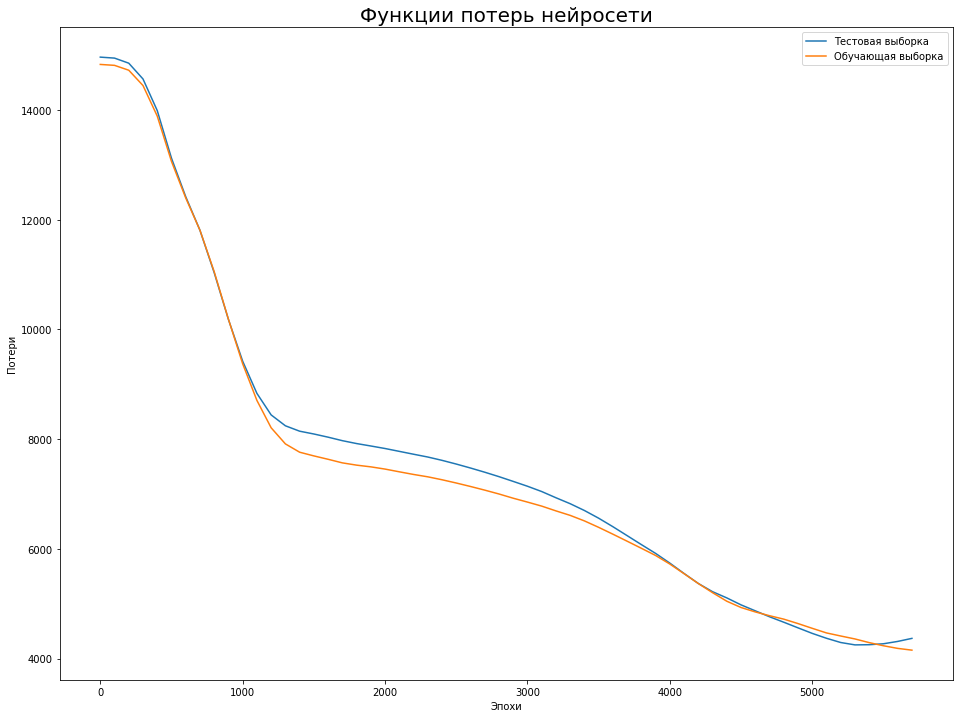



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [46]:
n_iter = 0                                                                           # номер итерации расчёта (счетчик)
columns_names = ['epoch', 'rmse_train', 'rmse_test', 'batch', 'dropout', 'func']     # название колонок для таблицы результатов
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)       # создаем архитектуру нейросети
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)                              # инициируем optimizer
loss = nn.L1Loss()                                                                   # инициируем функцию потерь
df_network = make_network(net, optimizer, loss)   # производим расчеты, собираем результаты и параметры в результирующую таблицу                 

Визуализируем качество прогнозирования нейросети: 

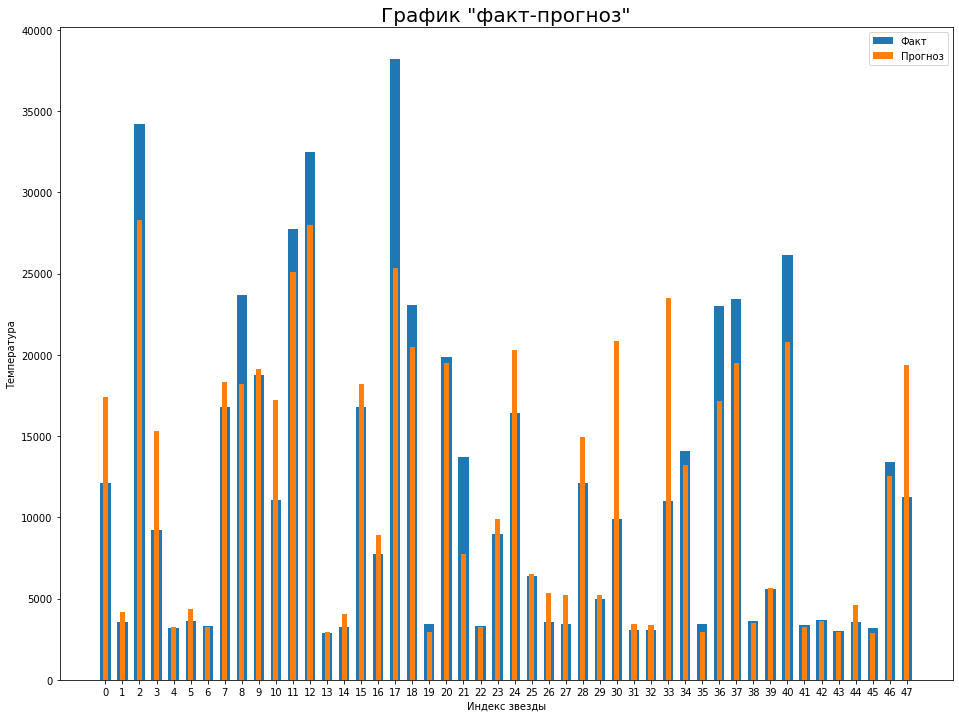

In [47]:
comparison_hist(df_network, target_valid)

## Улучшение нейронной сети
<a id="no_base_network"></a>

### Подбор гиперпараметров
<a id="hyper"></a>

Для улучшения качества нейросети делаем переменными следующие параметры:
- оптимизатор;
- функция потерь;
- dropout;
- batch.

In [48]:
dropout_list = [0, 0.5]                                                    # значения dropout
batch_list = [0, 1]                                                        # используется batch или нет
optimizer_list = ['Adam', 'SGD', 'RMSprop']                                # значения optimizer
loss_func_list = [nn.MSELoss(), nn.L1Loss()]                               # значения функции потерь
df_share = pd.DataFrame(columns=columns_names)                             # шаблон таблицы, в который будут добавляться результаты
test_select = False                                                        # переключатель валидационная/тестовая выборки

Вычисляем RMSE нейросети для разных параметров:

Параметры:
optimizer: Adam
loss function: MSELoss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4359.0206
Наименьшее RMSE получено на 5100.0 эпохе.


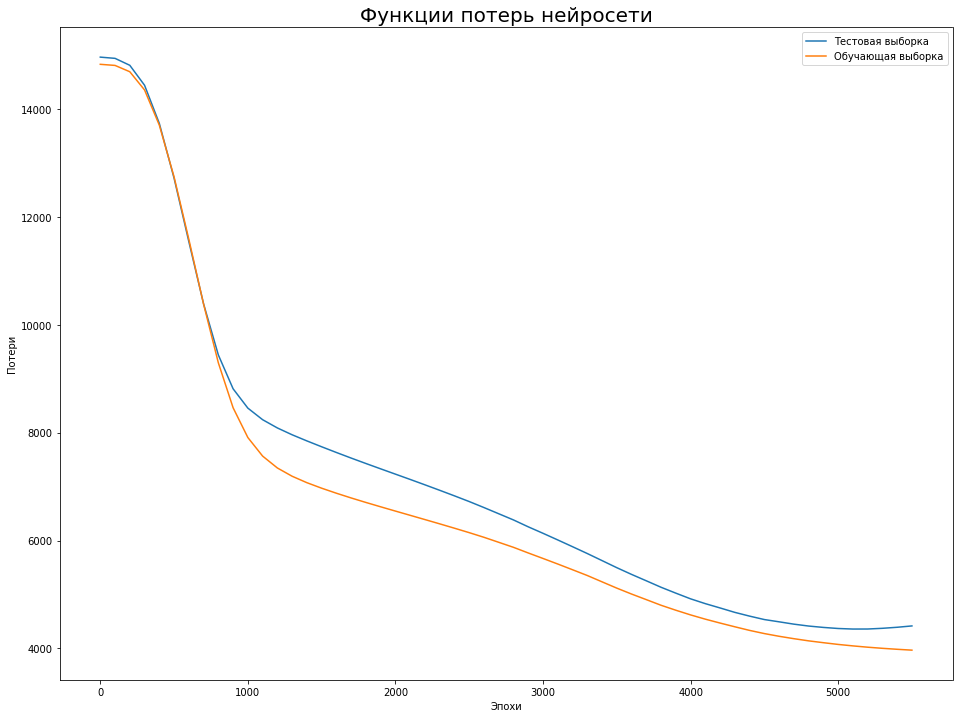



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: MSELoss()
dropout: 0.0
batch: True

Результаты:
Наименьшее RMSE: 4440.1574
Наименьшее RMSE получено на 5600.0 эпохе.


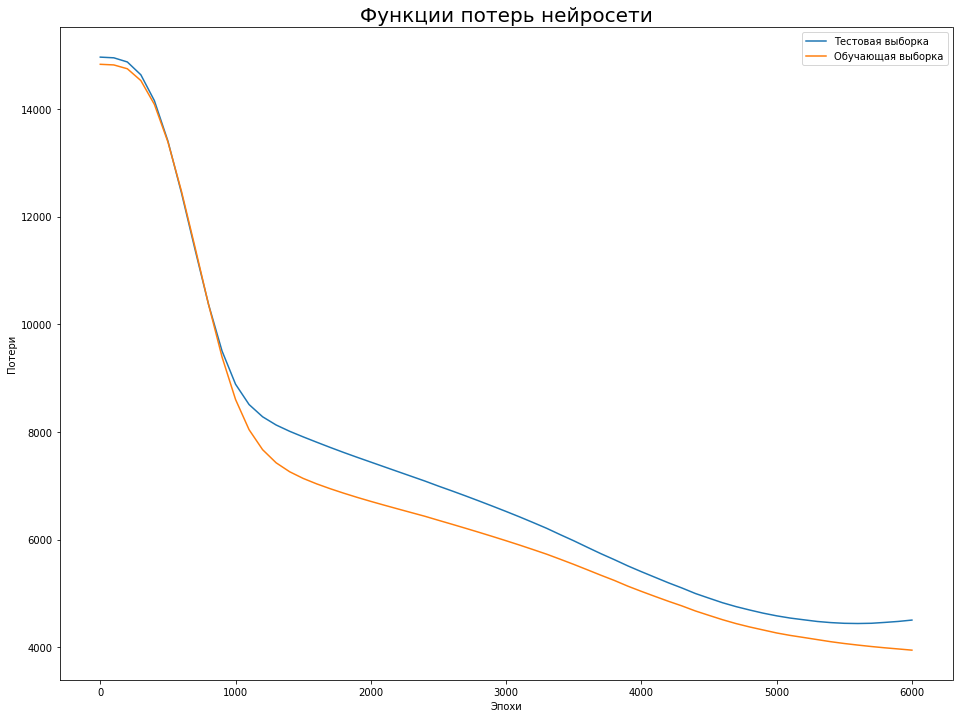



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: MSELoss()
dropout: 0.5
batch: False

Результаты:
Наименьшее RMSE: 4214.3666
Наименьшее RMSE получено на 15500.0 эпохе.


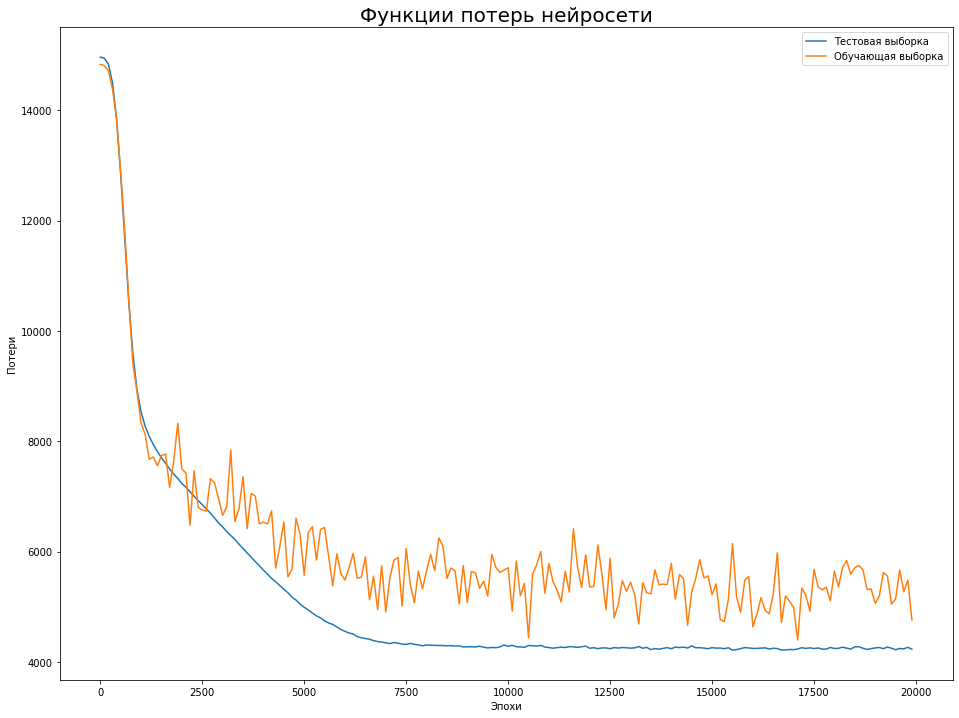



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: MSELoss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4131.9132
Наименьшее RMSE получено на 17700.0 эпохе.


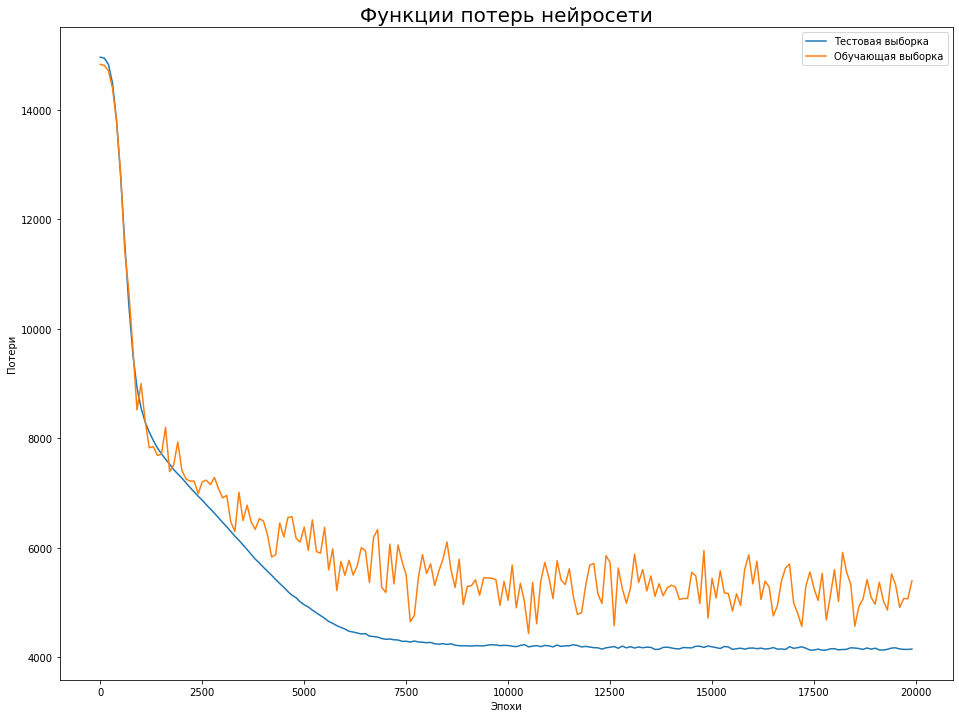



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4386.8640
Наименьшее RMSE получено на 7000.0 эпохе.


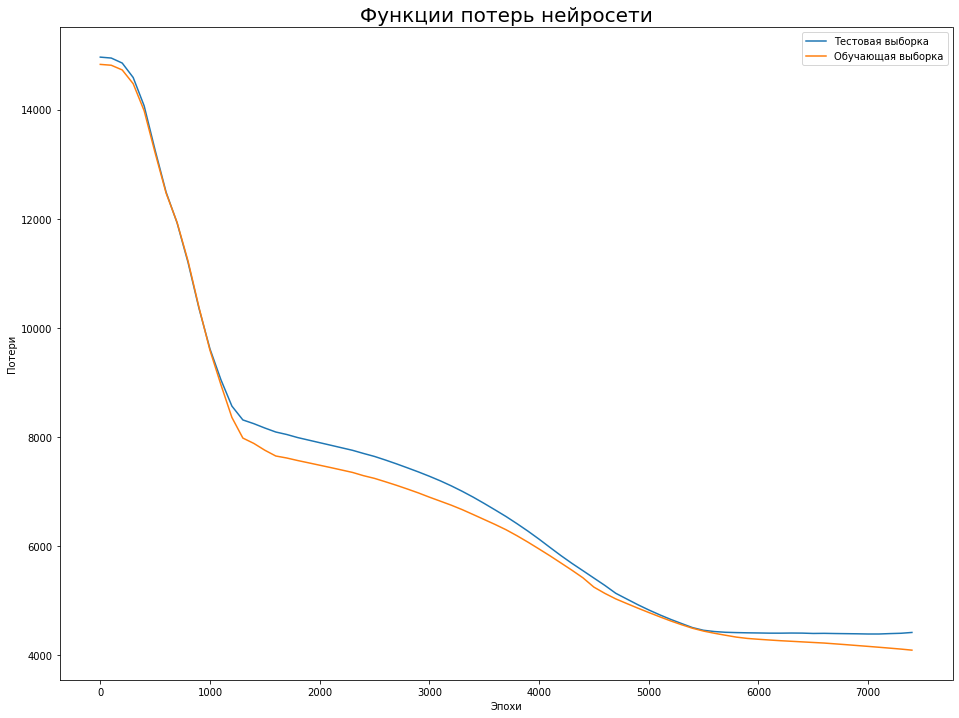



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.0
batch: True

Результаты:
Наименьшее RMSE: 4304.4421
Наименьшее RMSE получено на 5400.0 эпохе.


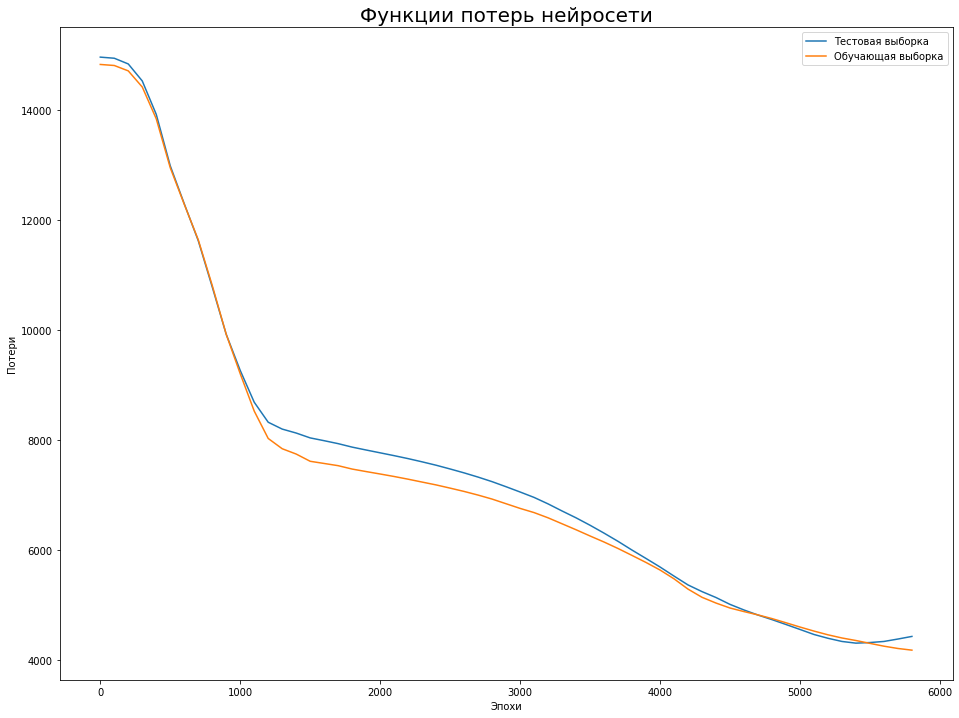



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.5
batch: False

Результаты:
Наименьшее RMSE: 4062.8505
Наименьшее RMSE получено на 17800.0 эпохе.


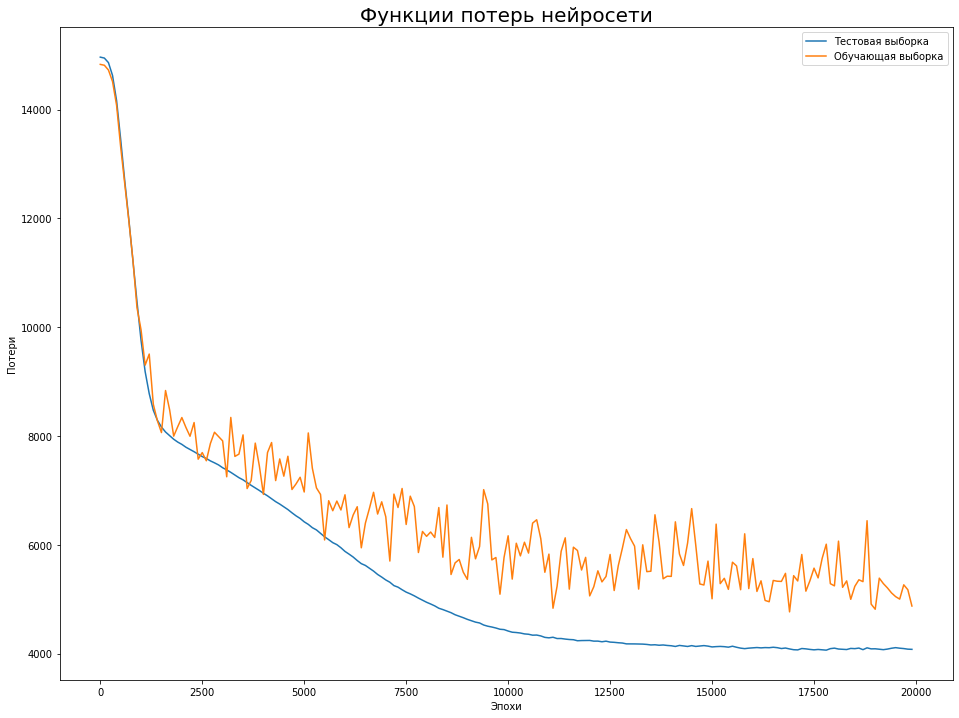



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4138.1037
Наименьшее RMSE получено на 14400.0 эпохе.


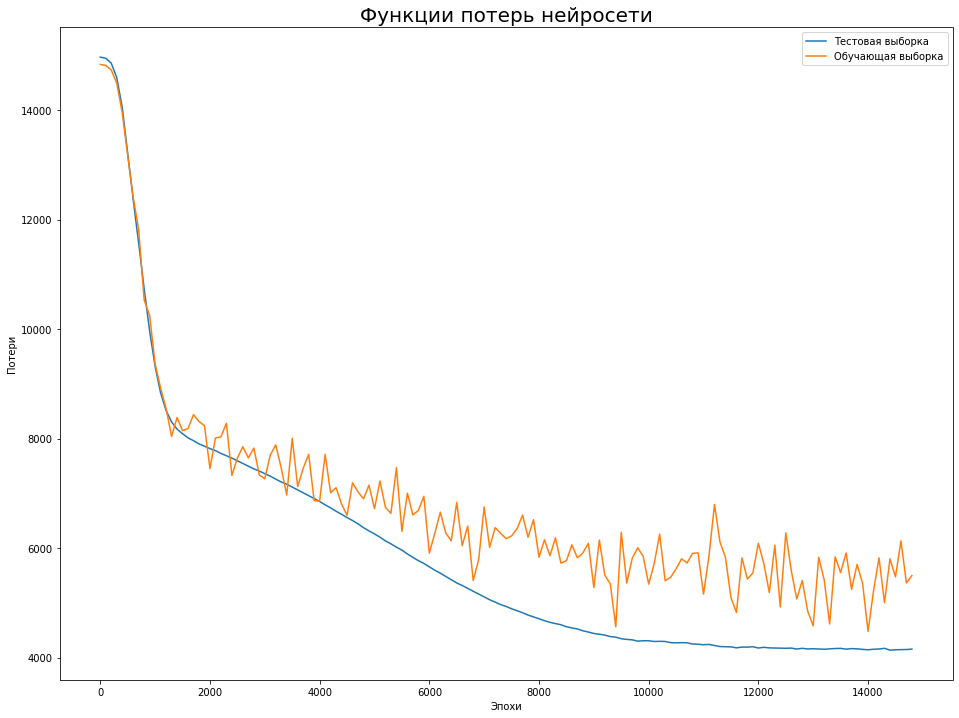



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: SGD
loss function: L1Loss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4637.2172
Наименьшее RMSE получено на 2000.0 эпохе.


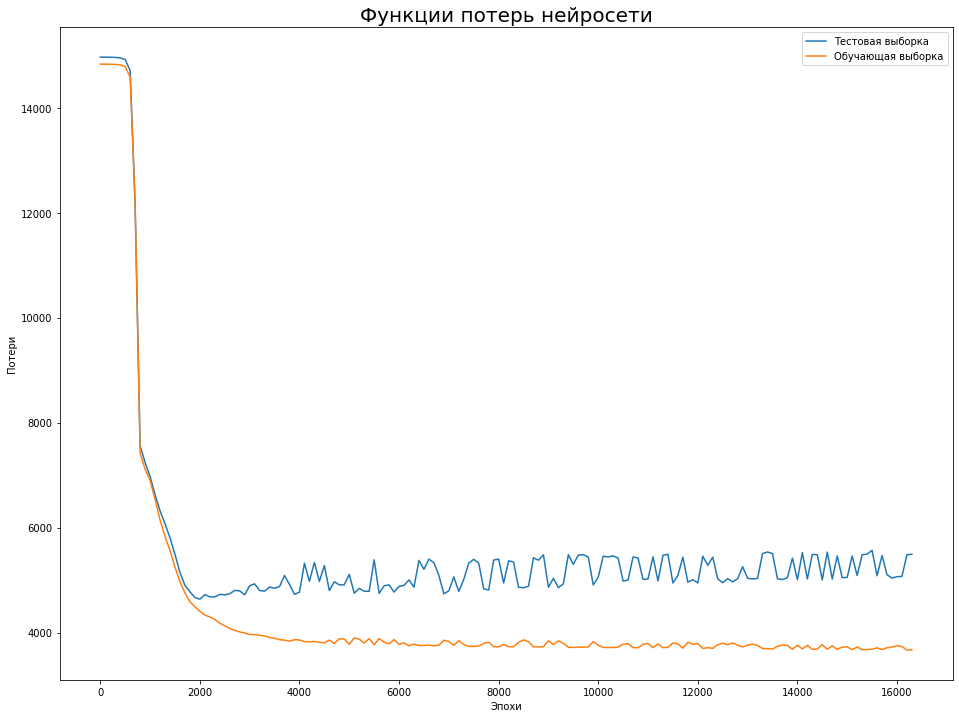



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: SGD
loss function: L1Loss()
dropout: 0.0
batch: True

Результаты:
Наименьшее RMSE: 4581.1797
Наименьшее RMSE получено на 2500.0 эпохе.


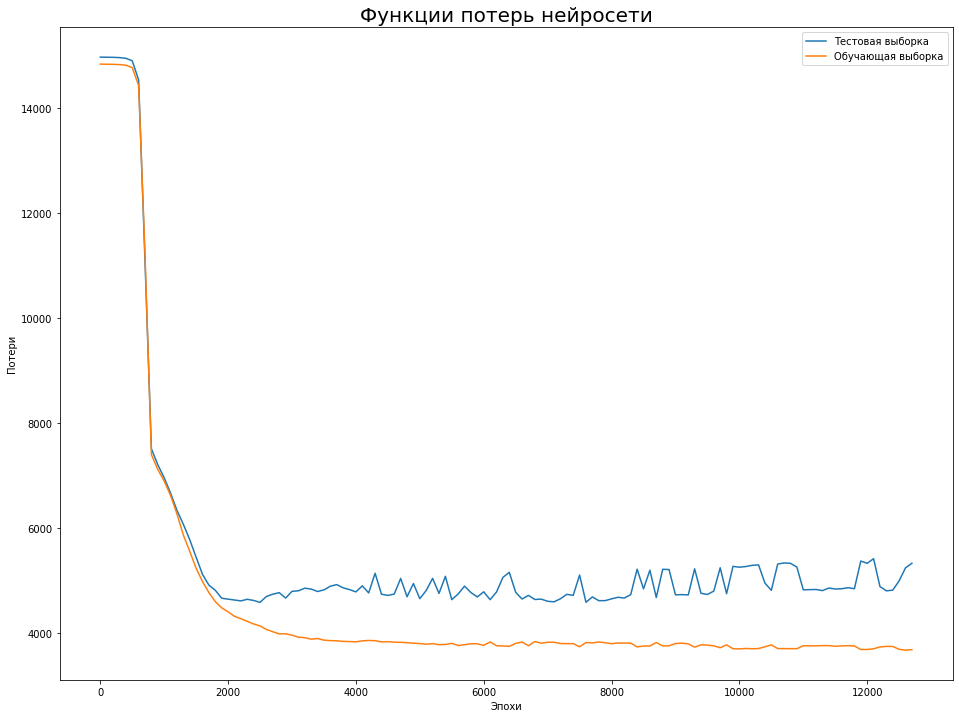



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: SGD
loss function: L1Loss()
dropout: 0.5
batch: False

Результаты:
Наименьшее RMSE: 4065.9452
Наименьшее RMSE получено на 3600.0 эпохе.


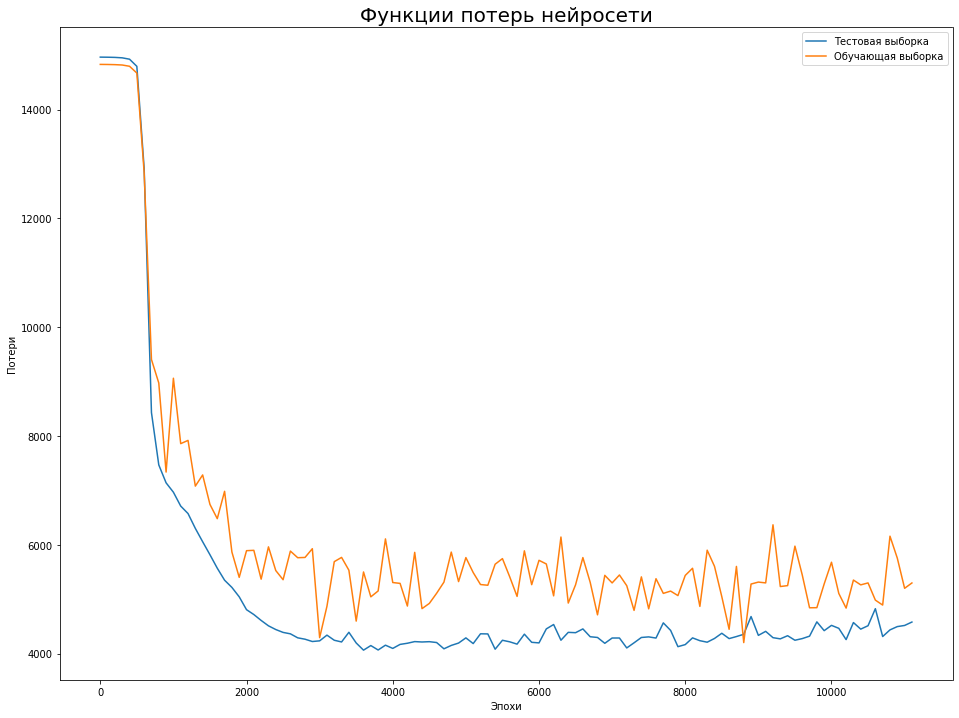



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: SGD
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 3996.8160
Наименьшее RMSE получено на 4500.0 эпохе.


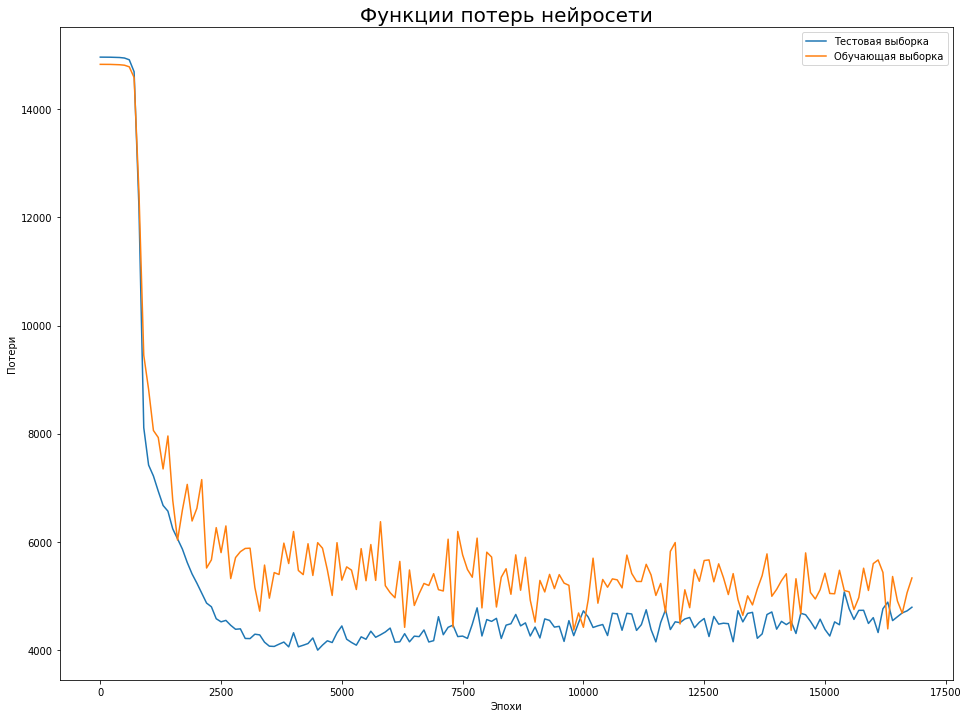



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: MSELoss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4719.0722
Наименьшее RMSE получено на 4100.0 эпохе.


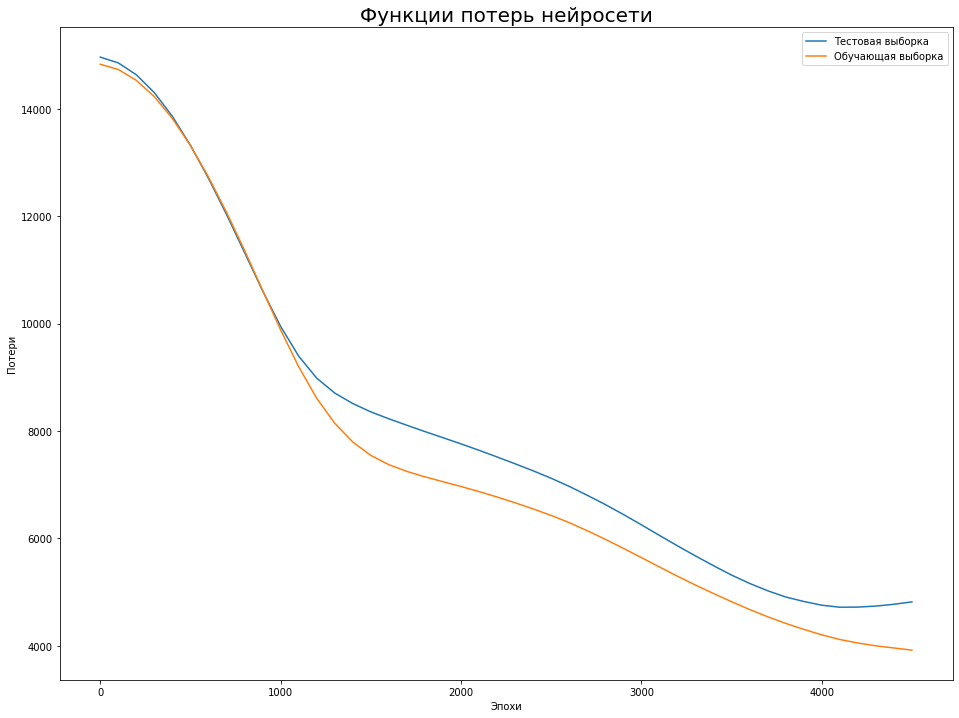



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: MSELoss()
dropout: 0.0
batch: True

Результаты:
Наименьшее RMSE: 4704.0870
Наименьшее RMSE получено на 4600.0 эпохе.


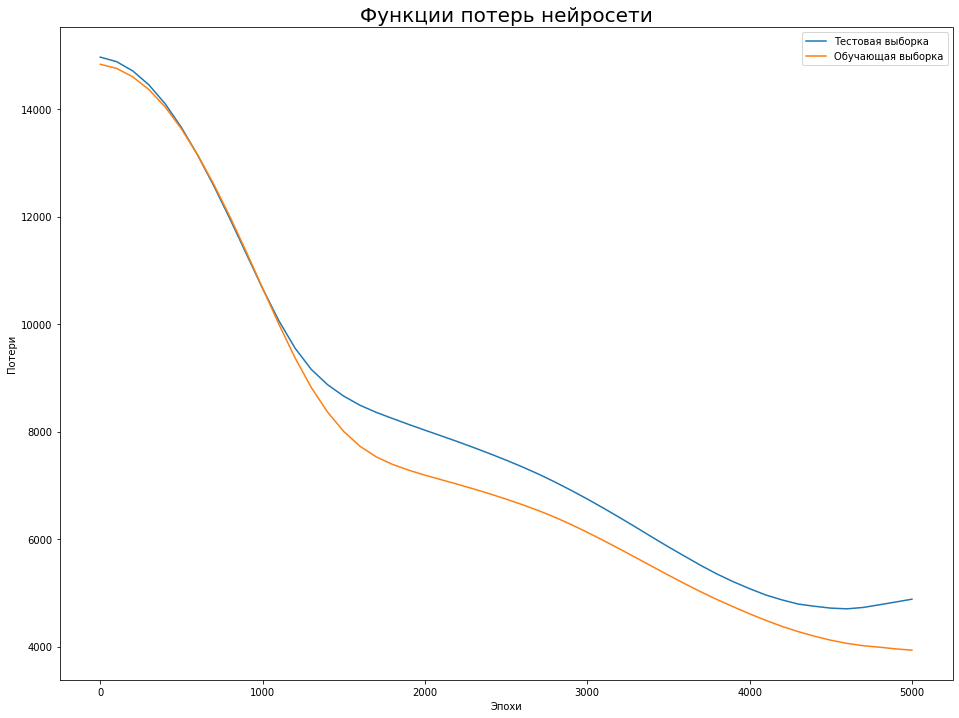



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: MSELoss()
dropout: 0.5
batch: False

Результаты:
Наименьшее RMSE: 4304.8273
Наименьшее RMSE получено на 16500.0 эпохе.


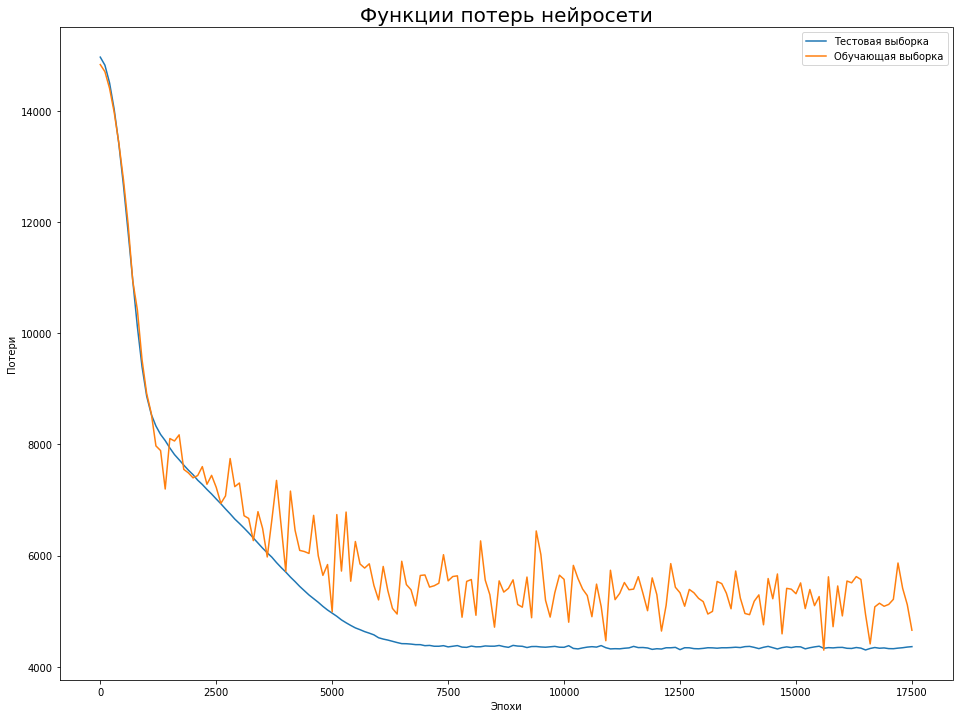



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: MSELoss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4193.2838
Наименьшее RMSE получено на 17000.0 эпохе.


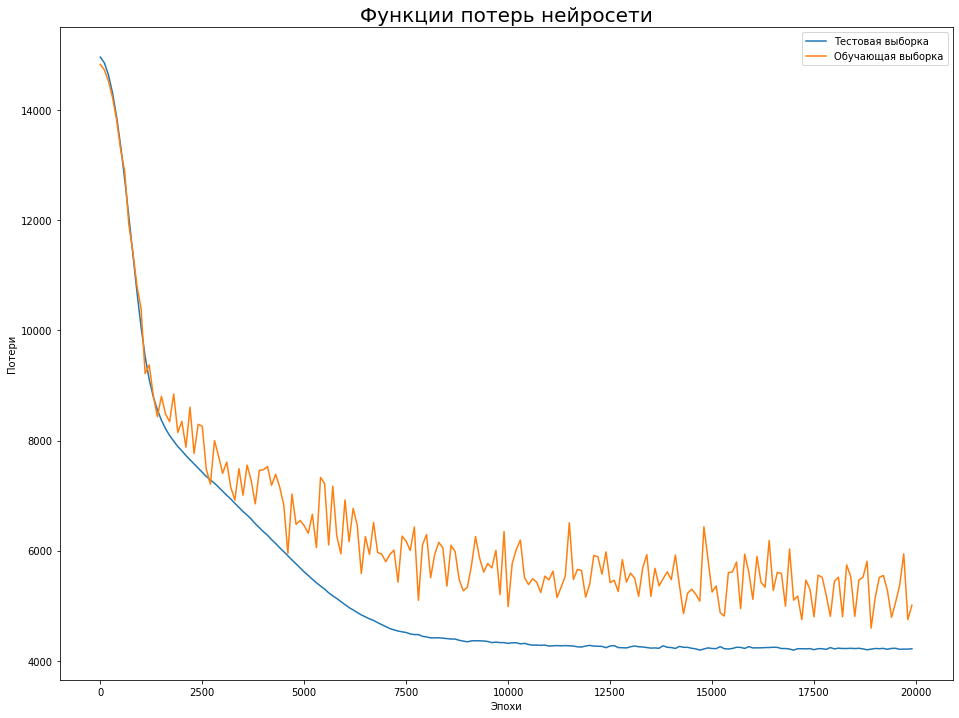



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4189.4610
Наименьшее RMSE получено на 5700.0 эпохе.


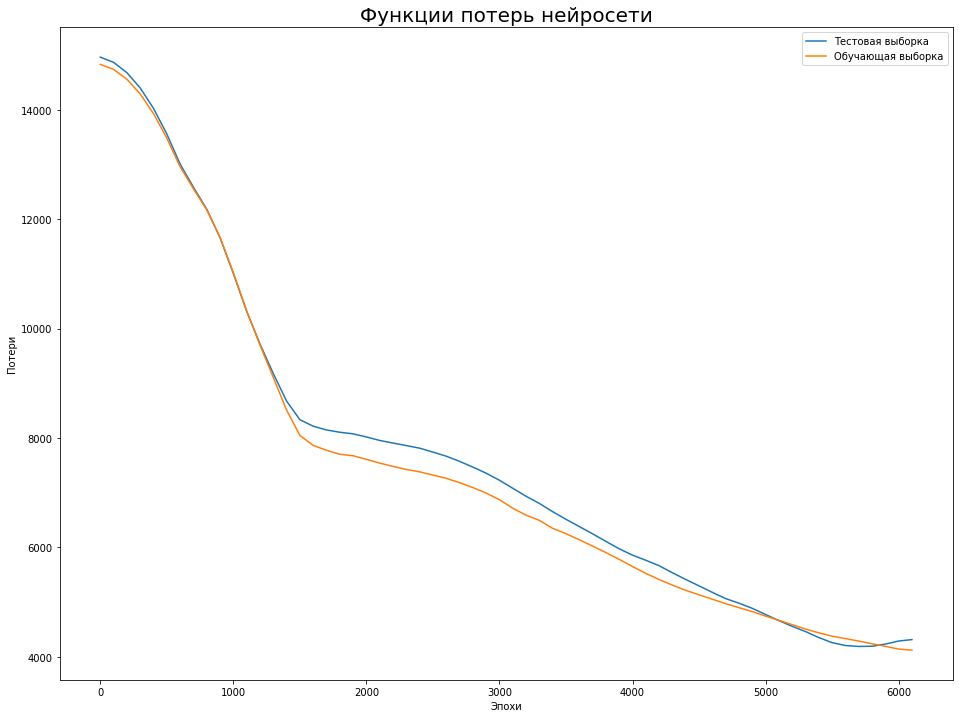



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.0
batch: True

Результаты:
Наименьшее RMSE: 4240.6232
Наименьшее RMSE получено на 5600.0 эпохе.


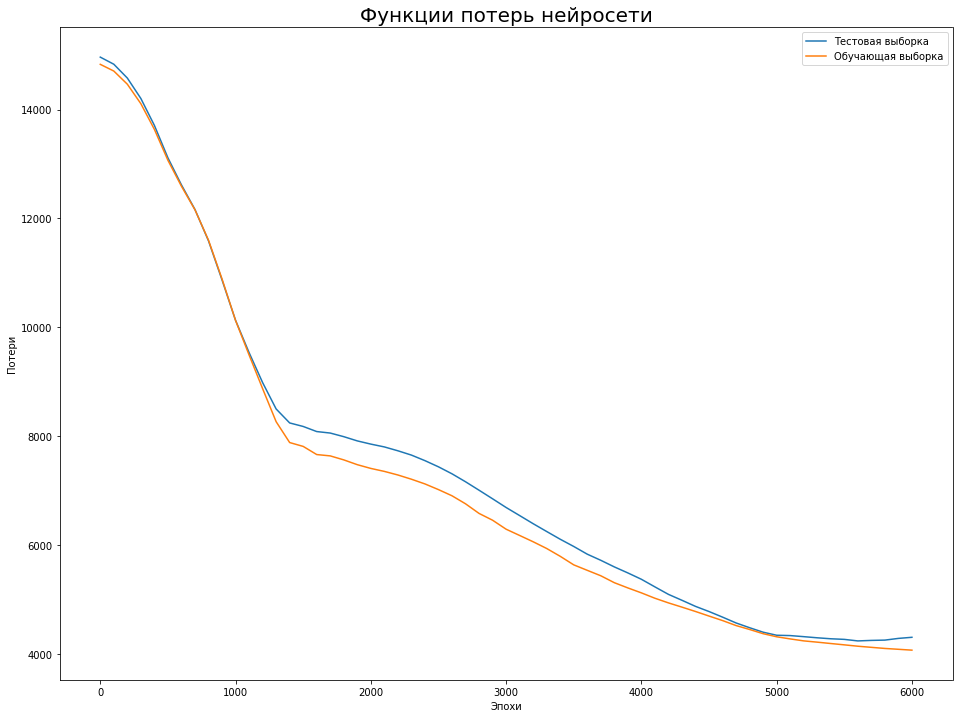



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.5
batch: False

Результаты:
Наименьшее RMSE: 4232.5644
Наименьшее RMSE получено на 19900.0 эпохе.


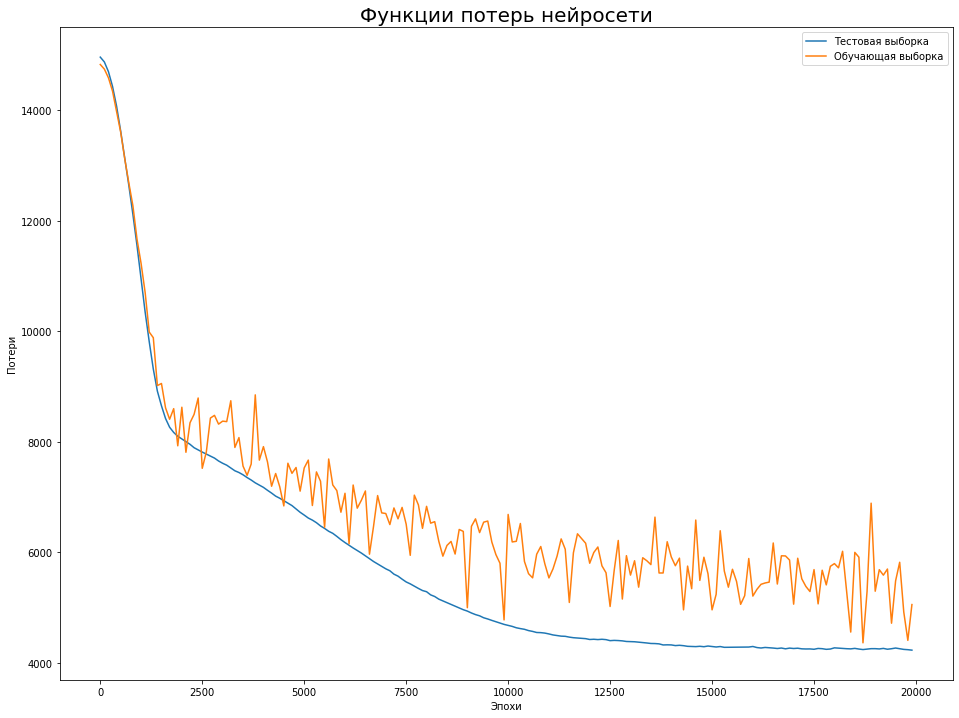



____________________________________________________________________________________________________
____________________________________________________________________________________________________


Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4147.4854
Наименьшее RMSE получено на 19600.0 эпохе.


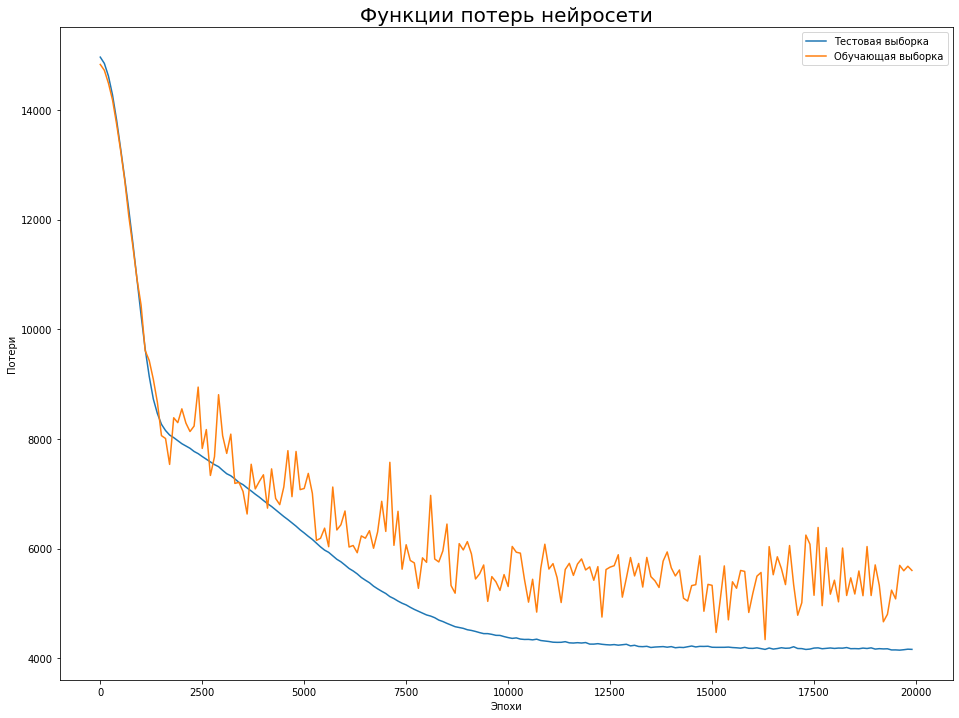



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [49]:
for optimizer_name in optimizer_list:                                    # перебераем значения optimizer
    for loss_func in loss_func_list:                                     # перебераем значения функции потерь
        for dropout in dropout_list:                                     # перебераем значения dropout
            for batch in batch_list:                                     # используется batch или нет
                # создаем архитектуру нейросети
                net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout, batch)
                # инициируем optimizer
                if optimizer_name == 'Adam':
                    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
                elif optimizer_name == 'SGD':
                    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
                else:
                    optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
                loss = loss_func  # инициируем функцию потерь
                # производим расчеты, собираем результаты и параметры в результирующую таблицу
                try:
                    # собираем в partial функцию обучения нейросети и ее аргументы
                    make_network_partial = partial(make_network, net, optimizer, loss, dropout, batch, test_select = False)
                    # производим обучение нейросети через partial
                    df_make_network_partial = make_network_partial()
                    # добавляем в таблицу partial (сохраняем аргументы функции расчёта нейросети для каждой итерации расчёта)
                    df_make_network_partial['func'] = make_network_partial
                    # объединяем рассчеты в результирующую таблицу
                    df_share = pd.concat([df_share, df_make_network_partial])
                except:
                    pass 

Наилучший результат на валидационной выборке:

Метрики и параметры лучшей нейросети:
Параметры:
optimizer: SGD
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 3996.8160
Наименьшее RMSE получено на 4500.0 эпохе.


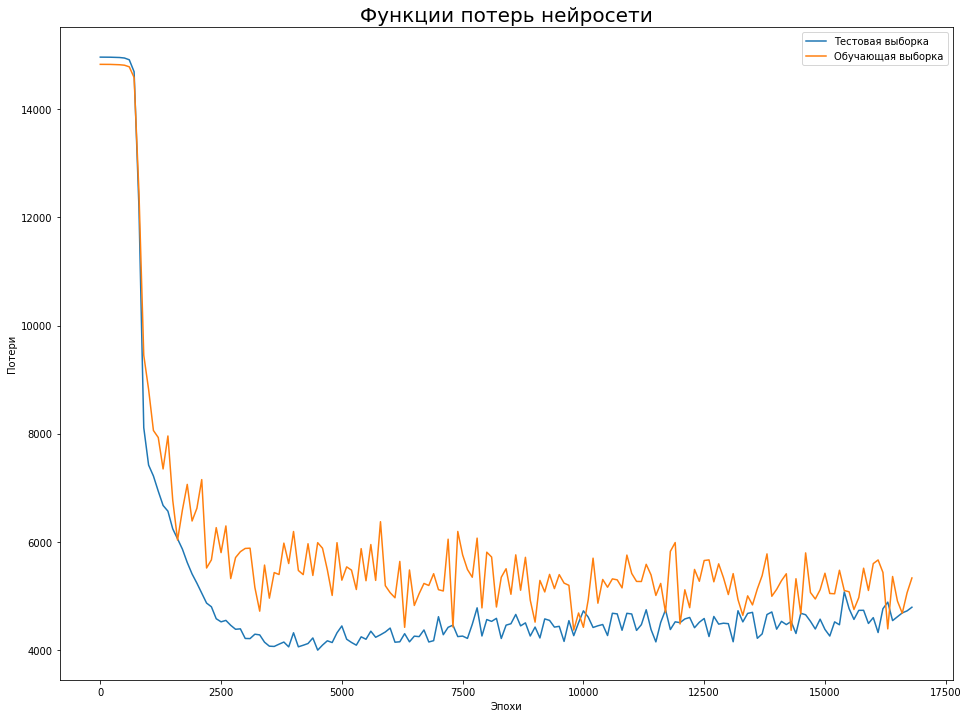



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [50]:
print('Метрики и параметры лучшей нейросети:')
# выводим строку с наименьшим rmse_test
best_iteration = df_share.sort_values(by='rmse_test').iloc[0, -1]
df_best = df_share.loc[df_share['n_iter'] == best_iteration].sort_values('epoch')
plot_score(df_best)

Визуализируем качество прогнозирования нейросети на валидационной выборке:

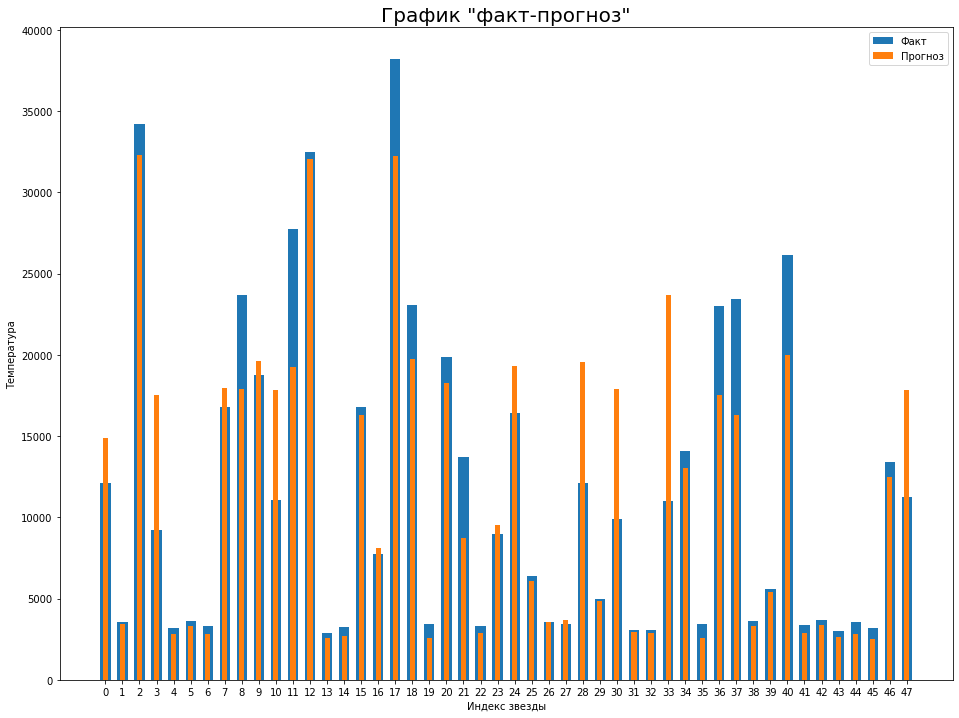

In [51]:
comparison_hist(df_share, target_valid)

### Проверка на тестовой выборке
<a id="test"></a>

Наилучший результат на тестовой выборке:

In [52]:
# создаем архитектуру нейросети
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
# инициируем optimizer значением нейросети с лучшим результатом на валидацтонной выборке
if str(make_network_partial.args[1]).split()[0] == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
elif str(make_network_partial.args[1]).split()[0] == 'SGD':
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
else:
    optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
# инициируем функцию потерь значением нейросети с лучшим результатом на валидацтонной выборке
loss = make_network_partial.args[2]
# инициируем dropout значением нейросети с лучшим результатом на валидацтонной выборке
dropout = make_network_partial.args[3]
# инициируем batch значением нейросети с лучшим результатом на валидацтонной выборке
batch = make_network_partial.args[4]

Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4237.4876
Наименьшее RMSE получено на 5500.0 эпохе.


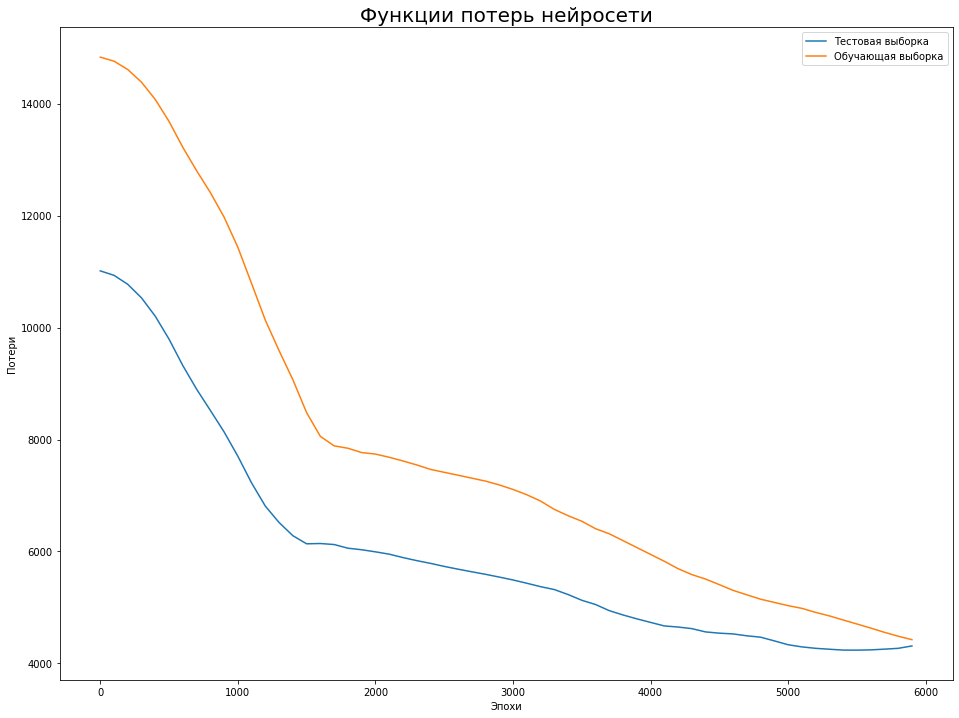



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [53]:
# собираем в partial функцию обучения нейросети и ее аргументы
best_rmse_test = partial(make_network, net, optimizer, loss, dropout, batch, test_select=True)
# производим обучение нейросети через partial
df_rmse_test = best_rmse_test()

Визуализируем качество прогнозирования нейросети на валидационной выборке:

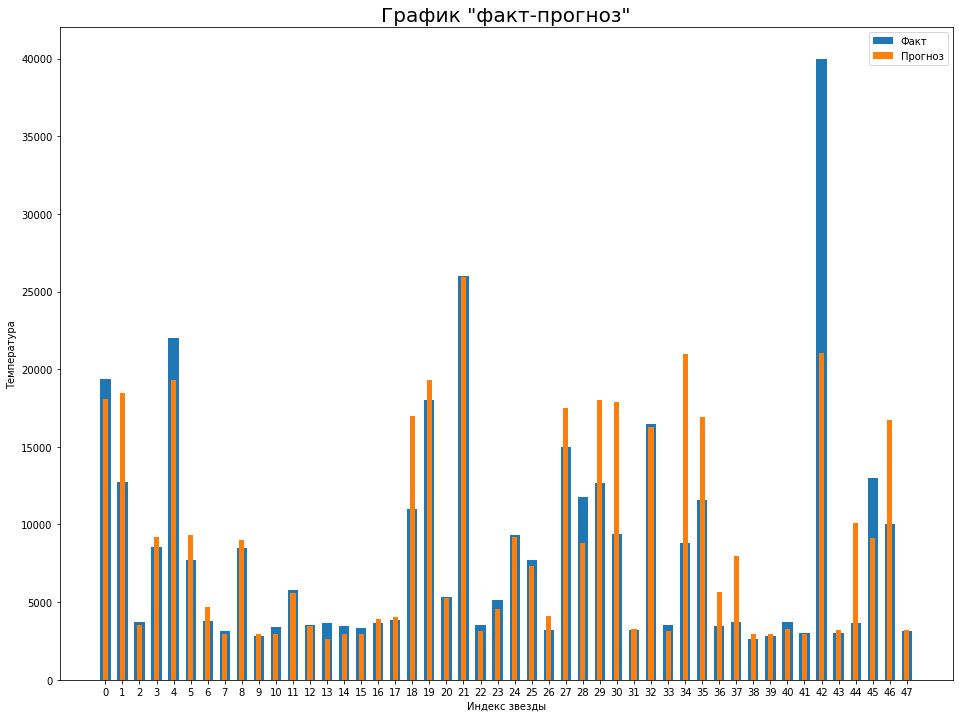

In [54]:
comparison_hist(df_rmse_test, target_test)

## Выводы
<a id="final"></a>

**Загрузка данных и общая информация**  

1. В датафрейме 240 строк и 7 признаков. Признак "Unnamed: 0" - лишний: дублирует индексы датафрейма.
2. Пропущенные значения отсутствуют.  
3. Следующие признаки имеют тип int64:  
 - Unnamed: 0;  
 - Temperature (K);  
 - Star type.  
 
 Следующие признаки имеют тип object:  
  - Star color.   

 Следующие признаки имеют тип float64:  
  - Luminosity(L/Lo);   
  - Radius(R/Ro);   
  - Absolute magnitude(Mv).   
  
  
4. Уникальные значения признака "Star color" не в полной мере соответствуют <a href="https://infogalactic.com/info/Stellar_classification">гарвардской спектральной классификации</a>: вперемешку идет классификация по обычному описанию цвета и фактически видимому цвету.  
5. Максимальное значение признака "Temperature (K)" в 2.65 раз выше значения третьего квартиля.
6. Максимальное значение признака "Luminosity(L/Lo)" в 4.29 раз выше значения третьего квартиля.
7. Максимальное значение признака "Radius(R/Ro)" в 45.58 раз выше значения третьего квартиля.  
8. Максимальное значение признака "Absolute magnitude(Mv)" в 1.46 раз выше значения третьего квартиля.

**Предобработка данных**  

1. Названия признаков приведены в соответствие с требованиями PEP 8.
2. Обнаружен 1 объект с аномальным значением признака. Но из исследования он не исключен.
3. Значения признака "star_color" приведены к единой форме. Устранены разночтения в классификации объектов по данному признаку. Количество уникальных значений сокращено с 19 до 7. 

**Исследовательский анализ данных**  

1. По типам объекты распределены равномерно - по 40 объектов каждого типа, кроме типа 5 (37 записей).  
2. В датасете наиболее широко (47.7%) представлены звезды цвета "light orange red".  
   Звезды цветов "blue" и "deep blue white" имеют 22.8% и 14.3% соответственно.  
   Количество звезд остальных цветов не превышает 6% для каждого цвета.  
3. Значения числовых признаков распределены неравномерно. Признаки "luminosity", "radius" и "temperature" концентрируются в области низких значений.  
    Значения абсолютной звёздной величины ("absolute_magnitude") концентрируются в диапазонах от -11.92 до -5 (яркие звезды) и с 9 до 20.06 (звезды с низкой яркостью).  
4. Количество звезд, меньших чем Солнце, превышает количество больших звезд на 11%.
5. Целевой признак "temperature" имеет значения корреляции с другими признаками:

    - "luminosity": 0.48;
    - "radius": 0.25;
    - "absolute_magnitude": -0.52.

    Наибольшая корреляция между "luminosity" и "radius": 0.89.
    Высокая обратная корреляция между:
    - "luminosity" и "absolute_magnitude": -0.89;
    - "radius" и "absolute_magnitude": -0.87.

   Из значений корреляции признака "absolute_magnitude" можно сделать вывод, что чем больше звезда, тем выше ее яркость.  
6. Среднее значение целевого признака "temperature" - 10497.5 K.  
   Стандартное отклонение целевого признака "temperature" - 9552.4 K.

**Подготовка данных к построению нейросети**  

1. Выборка разделена на обучающую и тестовую.
2. Произведено масштабирование числовых и кодирование (OHE) категориальных значений обучающей и тестовой выборки.

**Построение базовой нейронной сети**  

Построенная базовая нейронная сеть. Параметры и результаты приведены ниже:

Параметры:
optimizer: Adam
loss function: L1Loss()
dropout: 0.0
batch: False

Результаты:
Наименьшее RMSE: 4250.8835
Наименьшее RMSE получено на 5300.0 эпохе.


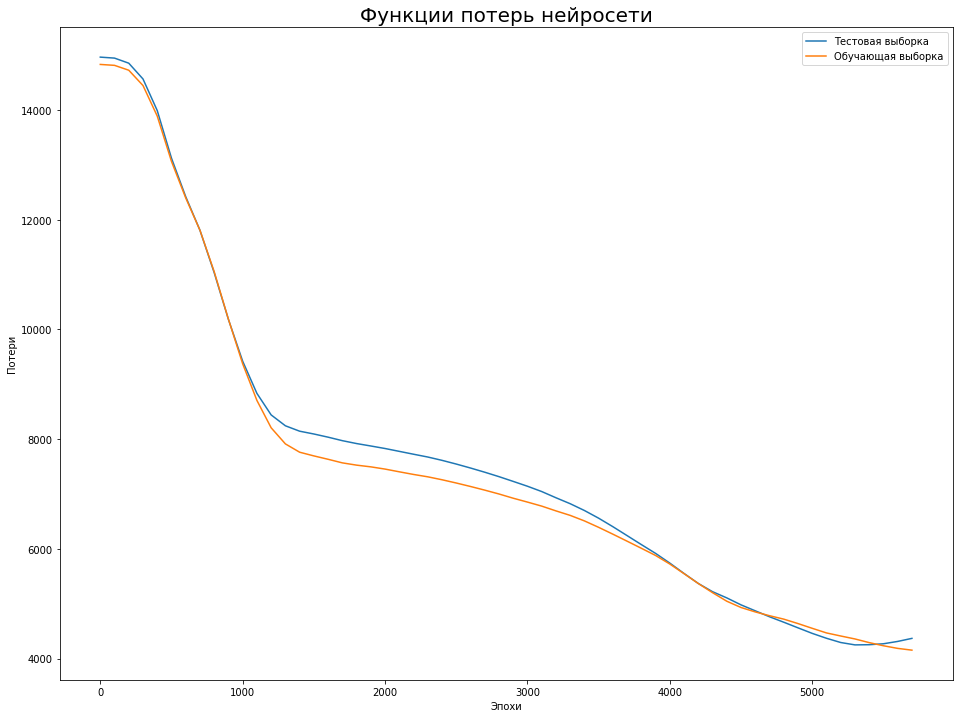



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [55]:
plot_score(df_network) 

**Улучшение нейронной сети**  

Качество нейросети оценивалось при переборе следующих параметров:
- оптимизатор (значения Adam, SGD, RMSprop);
- функция потерь (значения MSELoss, L1Loss);
- dropout (значения 0, 0.5);
- batch (значения True, False).

Параметры и результат на тестовой выборке лучшей нейросети приведены ниже.  
Значение RMSE на тестовой выборке меньше 4500 - условие выполнено.  

Параметры:
optimizer: RMSprop
loss function: L1Loss()
dropout: 0.5
batch: True

Результаты:
Наименьшее RMSE: 4237.4876
Наименьшее RMSE получено на 5500.0 эпохе.


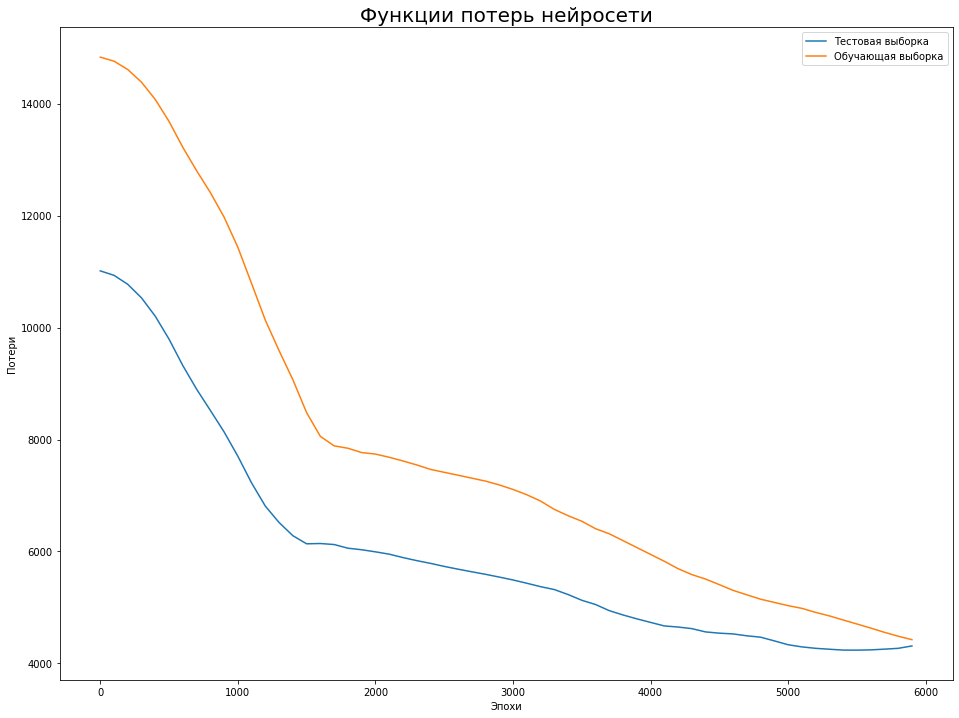



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [56]:
plot_score(df_rmse_test)